# this harmony code based on P1 previous data processing

In [1]:
setwd("/media/inspur/AS2150G2/LDK/sclc_metastasis/")
getwd()

[1] "/media/inspur/AS2150G2/LDK/sclc_metastasis"

In [ ]:
#### orignial code
library(Seurat)
library(harmony)
library("clusterProfiler")
library(org.Hs.eg.db)
library(ggplot2)
library(ggthemes)
library(RColorBrewer)
library(pheatmap)
library(ineq)
library(tidyverse)
library(hrbrthemes)
library(viridis)
library(reticulate)
# use_python ("~/.virtualenvs/r-reticulate/lib/python3.7/site-packages")

In [5]:
load("data_out/1.SCLC.filter.rdata") ### filtered output from P1
ls()

[1] "SCLC.filter"

In [6]:
# check metadata
head(SCLC.filter@meta.data)
table(SCLC.filter$sample)
sum(as.numeric(table(SCLC.filter$sample)))


orig.ident nCount_RNA nFeature_RNA percent.mt sample
S1_AAACGCTCATTAGGCT-1 S1         38063.560  6485          9.2669949 S1    
S1_AAACGCTGTACGACAG-1 S1         22451.609  4464         11.2228054 S1    
S1_AAACGCTGTTGTGCCG-1 S1         37911.320  5923         13.1976097 S1    
S1_AAAGAACGTAATTGGA-1 S1          3396.745  1552          5.2367781 S1    
S1_AAAGAACTCAACACCA-1 S1         21211.397  4539          0.8056408 S1    
S1_AAAGGATAGATTAGAC-1 S1         47046.122  6448          3.9217880 S1    
                      percent.HB RNA_snn_res.0.8 seurat_clusters
S1_AAACGCTCATTAGGCT-1 0          9               9              
S1_AAACGCTGTACGACAG-1 0          24              24             
S1_AAACGCTGTTGTGCCG-1 0          9               9              
S1_AAAGAACGTAATTGGA-1 0          6               6              
S1_AAAGAACTCAACACCA-1 0          16              16             
S1_AAAGGATAGATTAGAC-1 0          16              16


  S1   S2   S3   S4   S5   S6   S7 
1949 3992 5762 2738 2075 6361 1204 

[1] 24081

In [7]:
SCLC.filter <- NormalizeData(SCLC.filter, normalization.method = "LogNormalize", scale.factor = 10000)

SCLC.filter <- FindVariableFeatures(SCLC.filter, selection.method = "vst", nfeatures = 3000)
SCLC.filter <- ScaleData(SCLC.filter, features = VariableFeatures(object = SCLC.filter))

library(reticulate)
use_python ("~/.virtualenvs/r-reticulate/lib/python3.7/site-packages")

SCLC.filter <- RunPCA(SCLC.filter, npcs = 70, verbose = FALSE, features = VariableFeatures(object = SCLC.filter))

Centering and scaling data matrix



Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


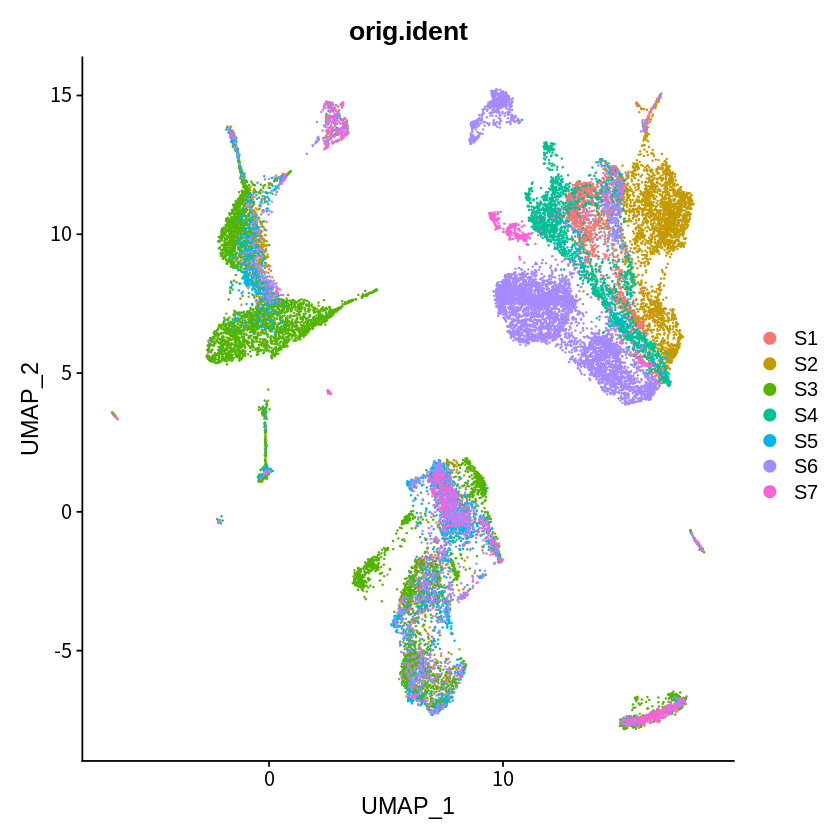

In [8]:
####### following harmony different batch/ patients as batch to remove batch effect
SCLC.filter <- RunHarmony(SCLC.filter, "orig.ident")
SCLC.filter <- RunUMAP(SCLC.filter, reduction = "harmony",dims=1:70,metric="correlation", umap.method = 'umap-learn',seed.use= 59) #59 63
DimPlot(SCLC.filter, reduction = "umap",group.by="orig.ident")

In [9]:
SCLC.filter <- FindNeighbors(SCLC.filter,reduction="harmony", dims = 1:70)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 24081
Number of edges: 1072653

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9118
Number of communities: 29
Elapsed time: 6 seconds


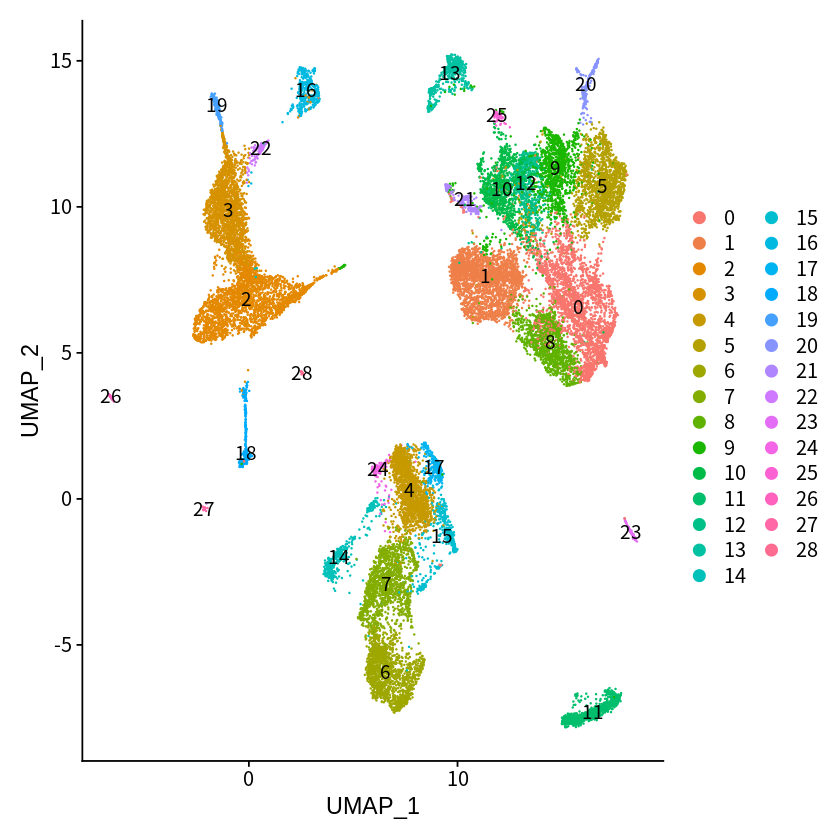

In [10]:
SCLC.filter <- FindClusters(SCLC.filter, resolution = 0.8)
DimPlot(SCLC.filter, reduction = "umap", label=T)

In [ ]:
SCLC.filter <- FindClusters(SCLC.filter, resolution = 0.9)
DimPlot(SCLC.filter, reduction = "umap", label=T)
table(SCLC.filter$seurat_clusters)

In [16]:
# save(SCLC.filter,file = "data_out/2_SCLC.filter_tmp.rdata")

## cell annotation 

In [12]:
# first calculate differential expression of each cell clusters and then enrich cell markers 
### based on PanglaoDB_markers using clusterProfiler packages

########markers 
library("clusterProfiler")
library(org.Hs.eg.db)

In [ ]:
### this step will take long time
SCLC.markers <- FindAllMarkers(SCLC.filter, only.pos = F, min.pct = 0.25, logfc.threshold = 0.25)

In [ ]:
# head(SCLC.markers);dim(SCLC.markers);table(SCLC.markers$cluster)
# save 
# write.csv(SCLC.markers, file="table_out/2_SCLC.markers.csv",quote=F)

In [19]:
SCLC.markers <- read.csv("table_out/2_SCLC.markers.csv",row.names = 1)

In [20]:
read.delim("data_input/PanglaoDB_markers_27_Mar_2020.tsv",header=T,sep="\t")->tmp_marker

tmp_marker [which(tmp_marker[,"organ"] %in% c("Immune system","Epithelium","Connective tissue","Lungs") & tmp_marker[, "species"] %in% c("Hs", "Mm Hs")),]-> tmp_marker2

cell_markers<-tmp_marker2[,c("cell.type","official.gene.symbol","organ")]

In [21]:
# ls()
head(cell_markers);dim(cell_markers)

cell.type                  official.gene.symbol organ            
53 Adipocyte progenitor cells CEBPA                Connective tissue
54 Adipocyte progenitor cells EGFR                 Connective tissue
55 Adipocyte progenitor cells FGF10                Connective tissue
56 Adipocyte progenitor cells GSC                  Connective tissue
57 Adipocyte progenitor cells MMP3                 Connective tissue
58 Adipocyte progenitor cells PPARG                Connective tissue

[1] 2347    3

In [22]:
cells=c()
for (k in 0: max(as.numeric(as.matrix(SCLC.markers[,"cluster"]))))
{
SCLC.markers[which(SCLC.markers[,"cluster"]==k & SCLC.markers[,"avg_log2FC"]> 0.0 & SCLC.markers[,"p_val_adj"]<0.1),"gene"] ->cand_gene

y <- enricher(cand_gene, universe=intersect(cell_markers[,2],rownames(SCLC.markers)),TERM2GENE=cell_markers, minGSSize=1,pvalueCutoff=0.2)
c(cells,paste(y[1:3,1],collapse="/"))->cells
}

In [24]:
paste0(c(0:max(as.numeric(as.matrix(SCLC.markers[,"cluster"])))), cells)

[1] "0Gamma delta T cells/Epithelial cells/Pulmonary alveolar type I cells"
 [2] "1Basal cells/NA/NA"                                                   
 [3] "2Monocytes/Neutrophils/Alveolar macrophages"                          
 [4] "3Monocytes/Macrophages/Dendritic cells"                               
 [5] "4T memory cells/T cells/Nuocytes"                                     
 [6] "5Fibroblasts/NA/NA"                                                   
 [7] "6NK cells/T cells/T memory cells"                                     
 [8] "7T cells/NK cells/T memory cells"                                     
 [9] "8Gamma delta T cells/Epithelial cells/NA"                             
[10] "9NA/NA/NA"                                                            
[11] "10Mast cells/NA/NA"                                                   
[12] "11B cells naive/B cells memory/B cells"                               
[13] "12Epithelial cells/Airway goblet cells/NA"                            
[14] "13Gamma delta T cells/NA/NA"                                          
[15] "14NK cells/T cells/T memory cells"                                    
[16] "15T memory cells/T cells/NK cells"                                    
[17] "16Macrophages/Dendritic cells/Monocytes"                              
[18] "17T memory cells/T cells/T helper cells"                              
[19] "18Megakaryocytes/Monocytes/Neutrophils"                               
[20] "19Monocytes/Macrophages/Dendritic cells"                              
[21] "20Epithelial cells/Basal cells/Fibroblasts"                           
[22] "21Epithelial cells/Basal cells/Pulmonary alveolar type II cells"      
[23] "22Dendritic cells/Monocytes/Macrophages"                              
[24] "23Plasma cells/B cells/B cells memory"                                
[25] "24T memory cells/T cells/NK cells"                                    
[26] "25Mast cells/Chondrocytes/NA"                                         
[27] "26Ciliated cells/Epithelial cells/Airway goblet cells"                
[28] "27Plasmacytoid dendritic cells/Dendritic cells/B cells"               
[29] "28Monocytes/Dendritic cells/Macrophages"

In [25]:

as.vector(cell_markers[which(cell_markers[,1]=="Dendritic cells"),"official.gene.symbol"])->test_genes
test_genes
library(ggplot2)
library(ggthemes)

# DoHeatmap(subset(SCLC.filter,downsample=300), features = test_genes ,slot="scale.data") + scale_fill_gradient2(breaks=seq(-10,10,0.1),low = "white", mid = "white", high = "#FF000090",midpoint=0)

[1] "IL6"      "CD86"     "CD83"     "CD1A"     "CR2"      "TLR9"    
  [7] "CD1C"     "CD209"    "LAMP3"    "CD1B"     "TREM2"    "FABP4"   
 [13] "S100A9"   "ARG1"     "HLA-DRA"  "HLA-DQA1" "HLA-DMB"  "HLA-DMA" 
 [19] "HLA-DQB1" "CLEC10A"  "HLA-DRB1" "HLA-DPA1" "HLA-DPB1" "DNASE1L3"
 [25] "CLEC9A"   "LILRB2"   "ETV6"     "CD163"    "CXCR4"    "CXCL8"   
 [31] "VSIG4"    "NR4A3"    "CCR7"     "TRAF1"    "RELB"     "BATF3"   
 [37] "CCL22"    "SLAMF7"   "XCR1"     "CXCL16"   "SCIMP"    "FCGR2B"  
 [43] "FGD2"     "RAB7B"    "NAAA"     "HCK"      "CD180"    "HFE"     
 [49] "CCR2"     "RYR1"     "ITGAE"    "SEMA4A"   "DPP4"     "SLAMF8"  
 [55] "CXCR3"    "BTLA"     "FLT3"     "TLR3"     "ITGAX"    "GPR132"  
 [61] "ADAM19"   "AP1S3"    "ASS1"     "ADGRG5"   "GPR68"    "KIT"     
 [67] "KMO"      "P2RY10"   "RAB30"    "SEPT6"    "ZBTB46"   "S100A4"  
 [73] "CLEC7A"   "AIF1"     "LST1"     "CTSS"     "IRF8"     "ADGRE1"  
 [79] "CCL17"    "CD14"     "CD207"    "CD8A"     "CX3CR1"   "ITGAM"   
 [85] "LY75"     "PDCD1LG2" "PTPRC"    "SIRPA"    "FCGR3A"   "FTL"     
 [91] "SERPINA1" "AXL"      "PPP1R14A" "SIGLEC6"  "CD22"     "DAB2"    
 [97] "S100A8"   "VCAN"     "LYZ"      "ANXA1"    "FCER1A"   "C1ORF54" 
[103] "CADM1"    "CAMK2D"   "LGALS3"   "NAPSA"    "PLBD1"    "RNASE6"  
[109] "PLAC8"    "H2AFY"    "SLC11A1"  "PDPN"     "S100B"    "CD28"    
[115] "PPL"      "SLURP1"   "HLA-A"    "HLA-B"    "HLA-C"    "HLA-DRB5"
[121] "SERPINB9"

Centering and scaling data matrix

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



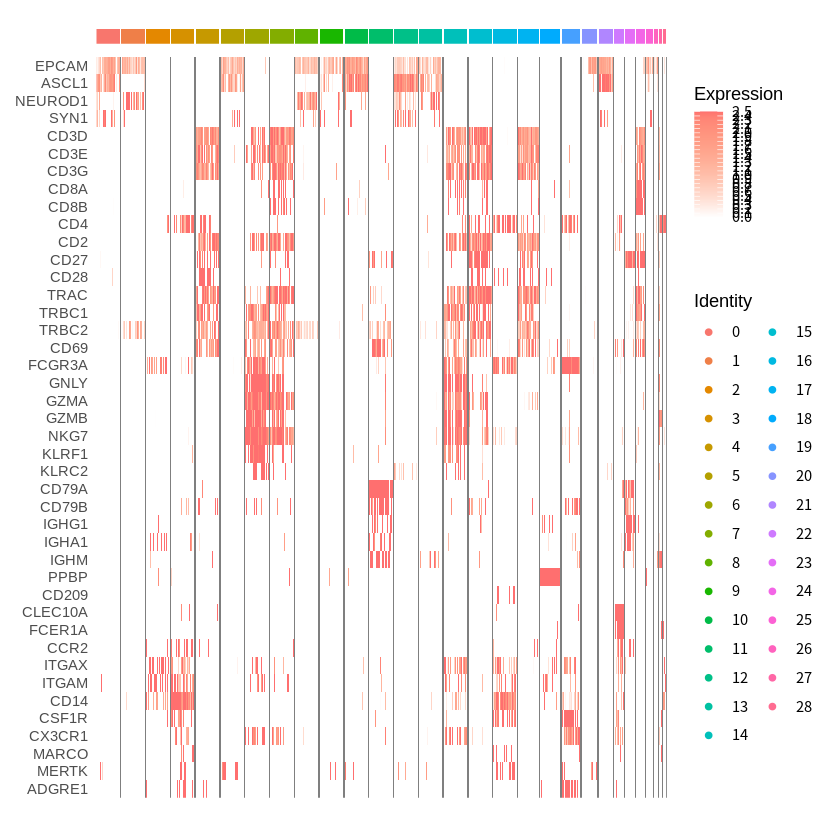

In [11]:
library(ggplot2)

#######Figures 1 

#gene_marker2=c("EPCAM","ASCL1","NEUROD1","SYN1","CD3D","CD3E","CD3G","CD8A","CD8B","CD4","CD2","CD27","CD28","TRAC","TRBC1","TRBC2","CD69","FCGR3A","GNLY","GZMA","GZMB","NKG7","KLRF1","KLRC2","CD79A","CD79B","IGHG1","IGHA1","IGHM","PPBP","CD209","CLEC10A","FCER1A","CCR2","ITGAX","ITGAM","CD14","CSF1R","CX3CR1","CD68","CD163","MARCO","MSR1","MRC1","APOE","MCEMP1") ### cell type and definitions
gene_marker2=c("EPCAM","ASCL1","NEUROD1","SYN1","CD3D","CD3E","CD3G","CD8A","CD8B","CD4","CD2","CD27","CD28","TRAC","TRBC1","TRBC2","CD69","FCGR3A","GNLY","GZMA","GZMB","NKG7","KLRF1","KLRC2","CD79A","CD79B","IGHG1","IGHA1","IGHM","PPBP","CD209","CLEC10A","FCER1A","CCR2","ITGAX","ITGAM","CD14","CSF1R","CX3CR1","MARCO","MERTK","ADGRE1") ### cell type and definitions
SCLC.filter <- ScaleData(SCLC.filter, features = gene_marker2)
DoHeatmap(subset(SCLC.filter,downsample=300), features = gene_marker2 ,size=3,label=FALSE) + scale_fill_gradient2(breaks=seq(0,8,0.1),low = "white", mid = "white", high = "#FF000090",midpoint=0)
#DoHeatmap(subset(SCLC.filter,downsample=300), size=3,features = gene_marker2 ,slot="scale.data") + scale_fill_gradient2(breaks=seq(-10,10,0.1),low = "white", mid = "white", high = "#FF000090",midpoint=0)

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”
Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


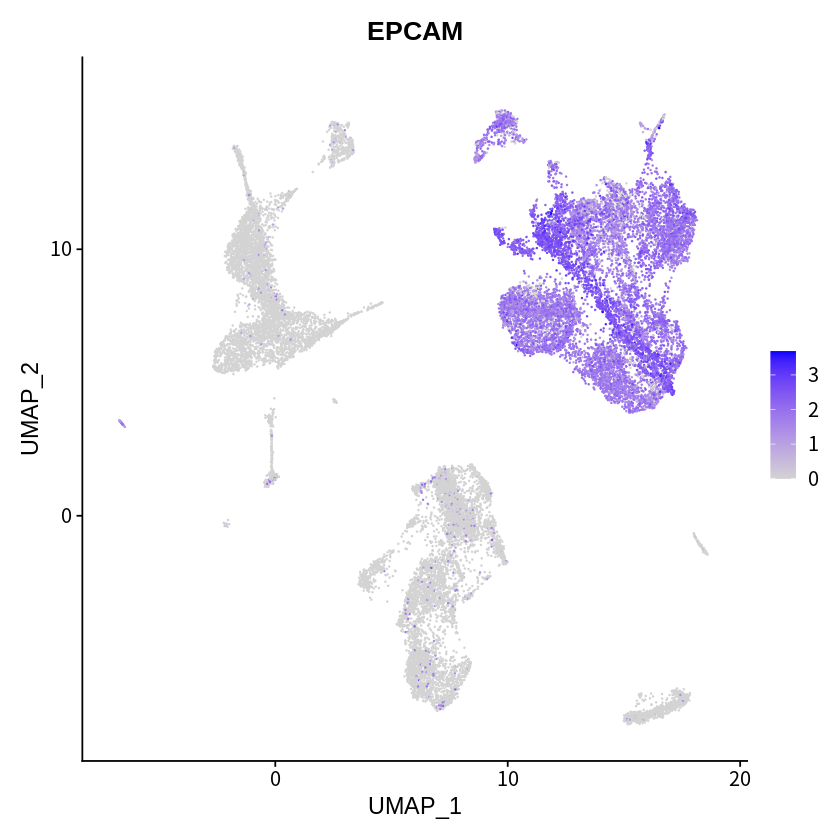

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


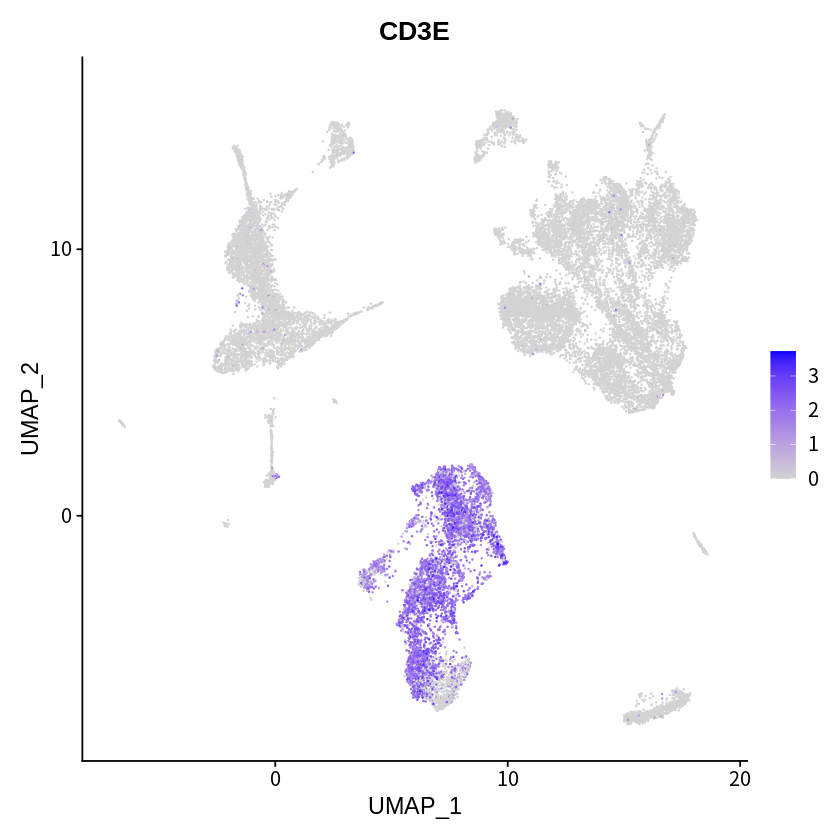

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


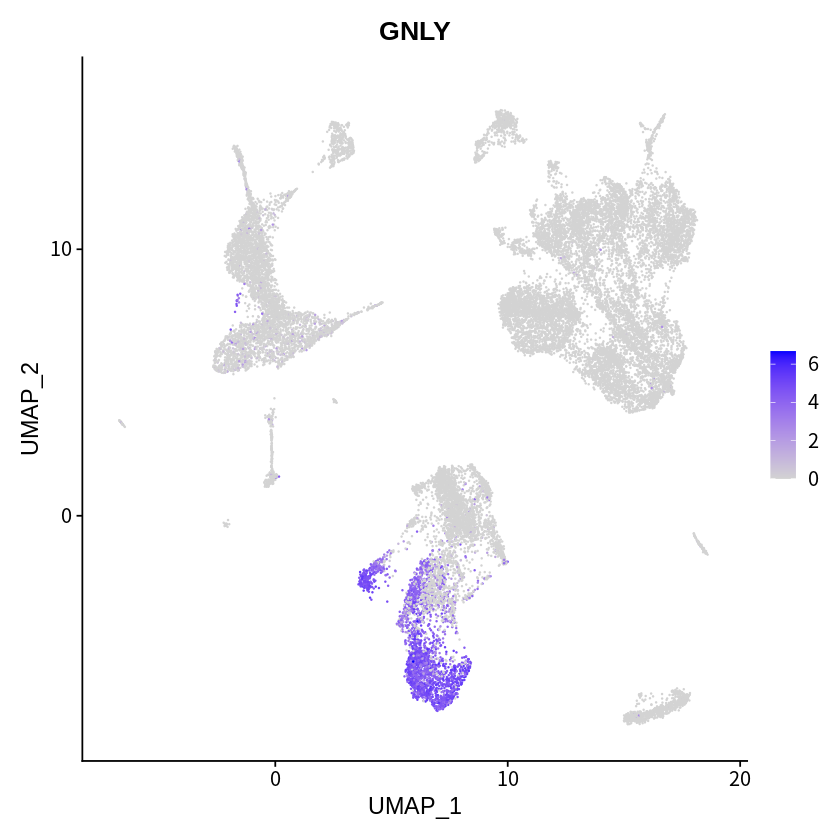

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


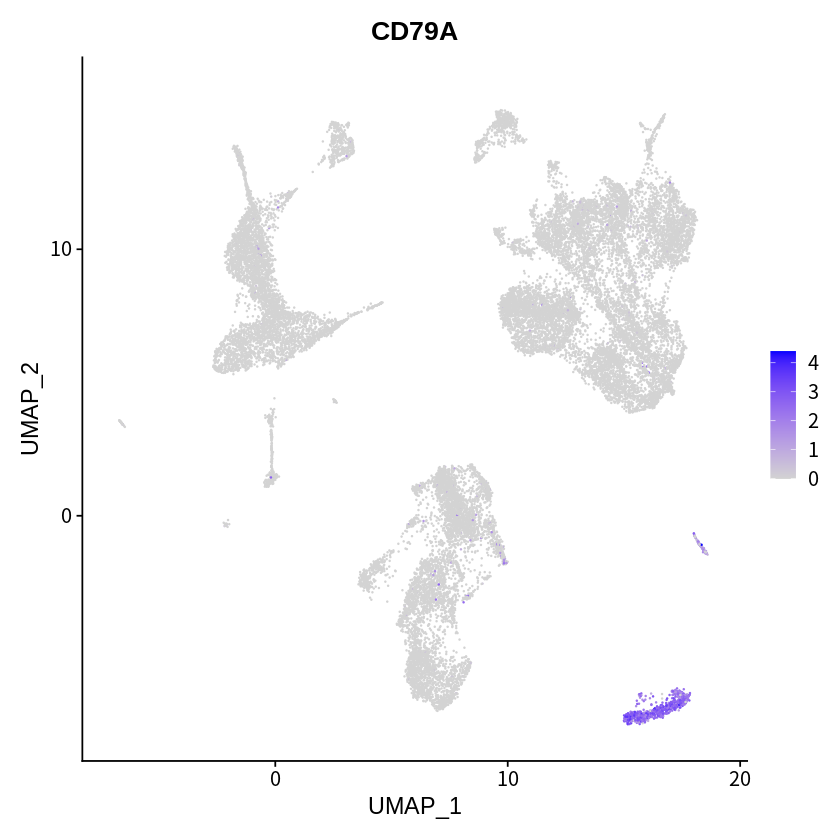

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


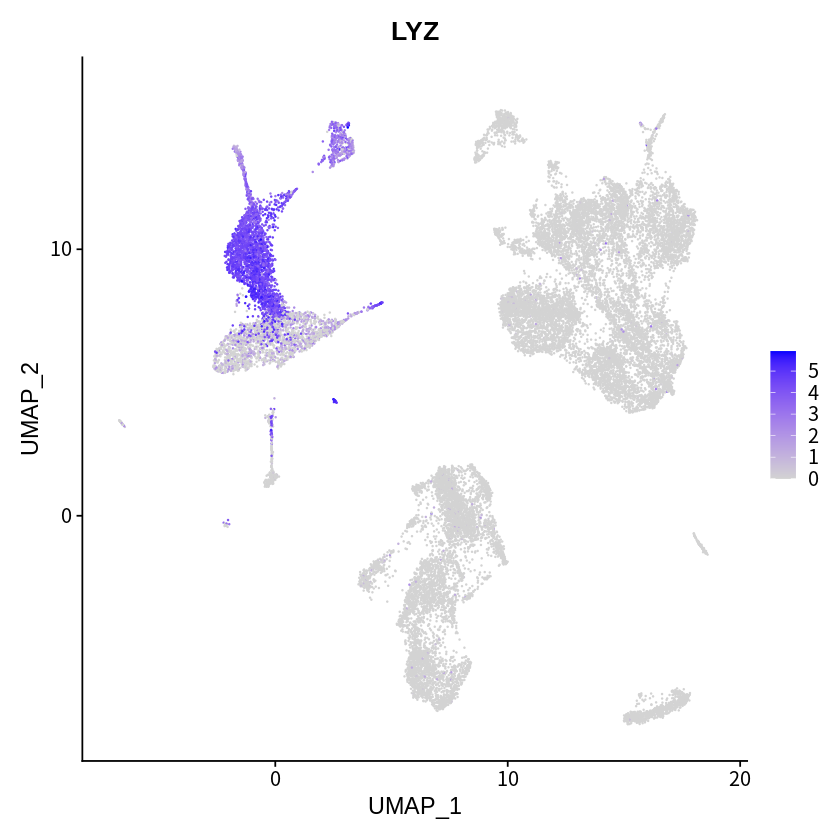

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


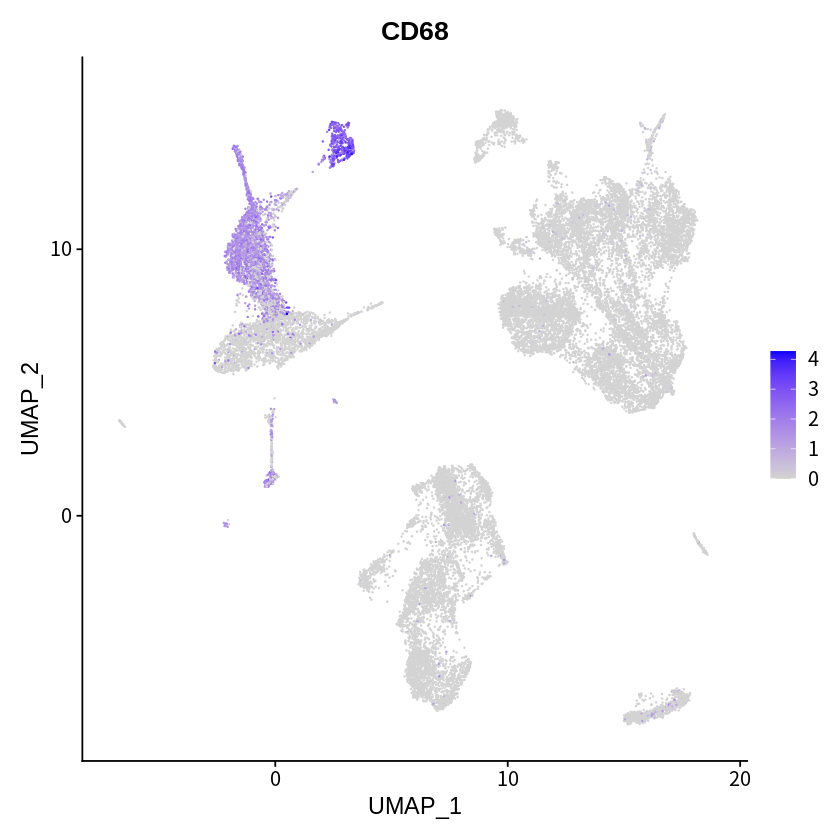

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


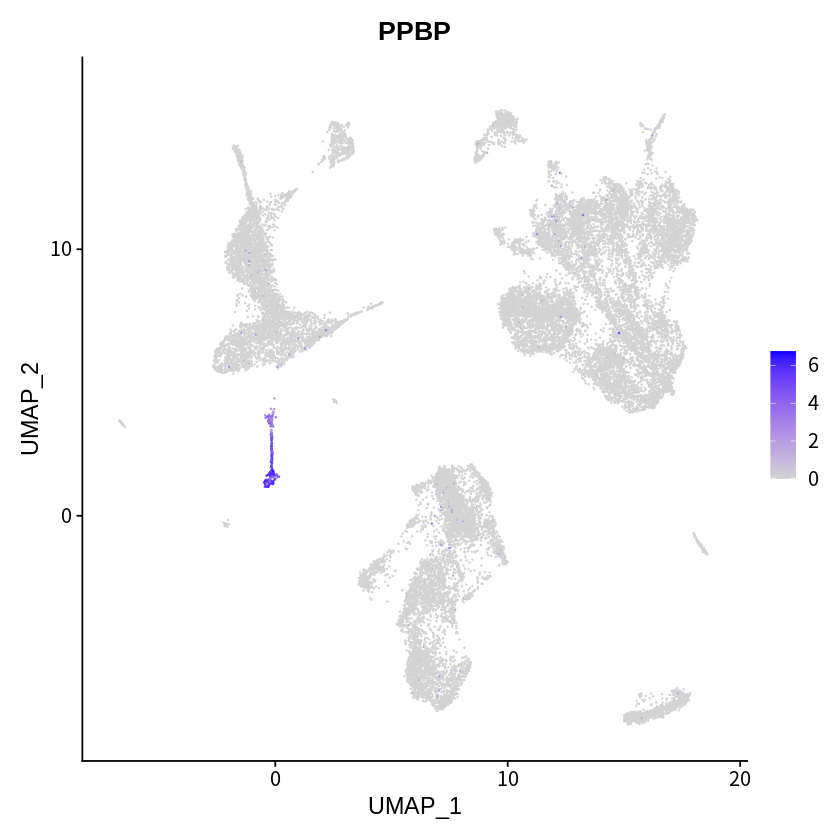

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


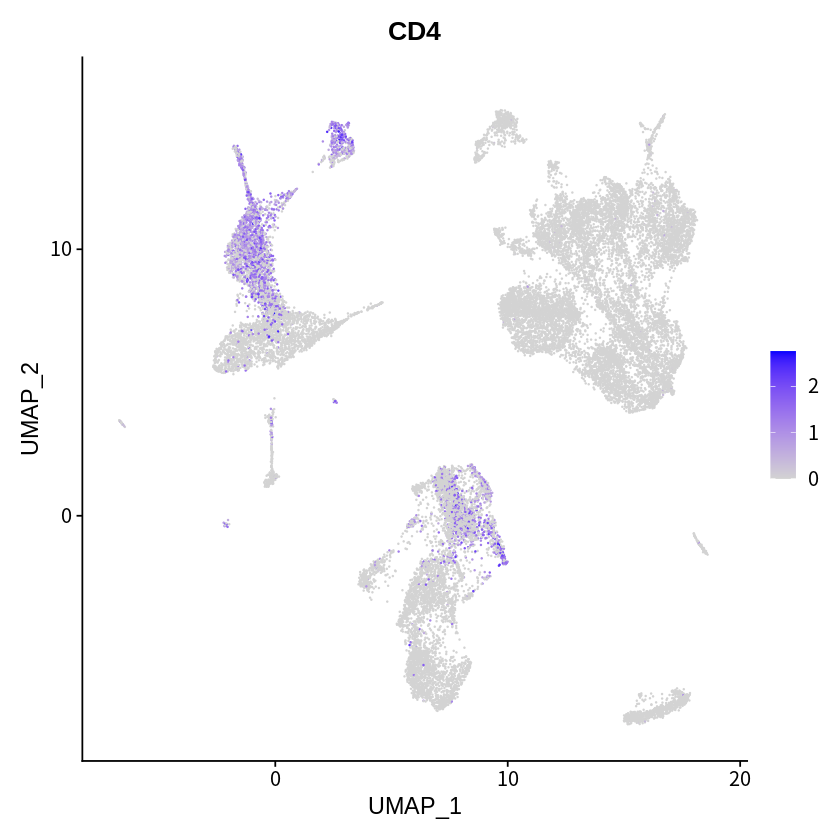

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


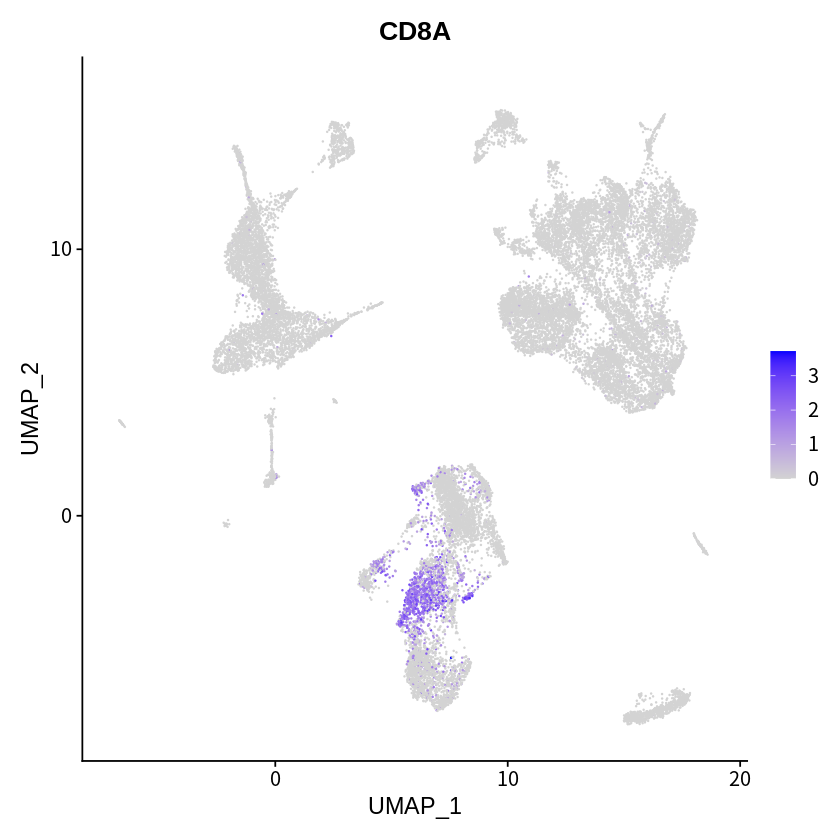

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


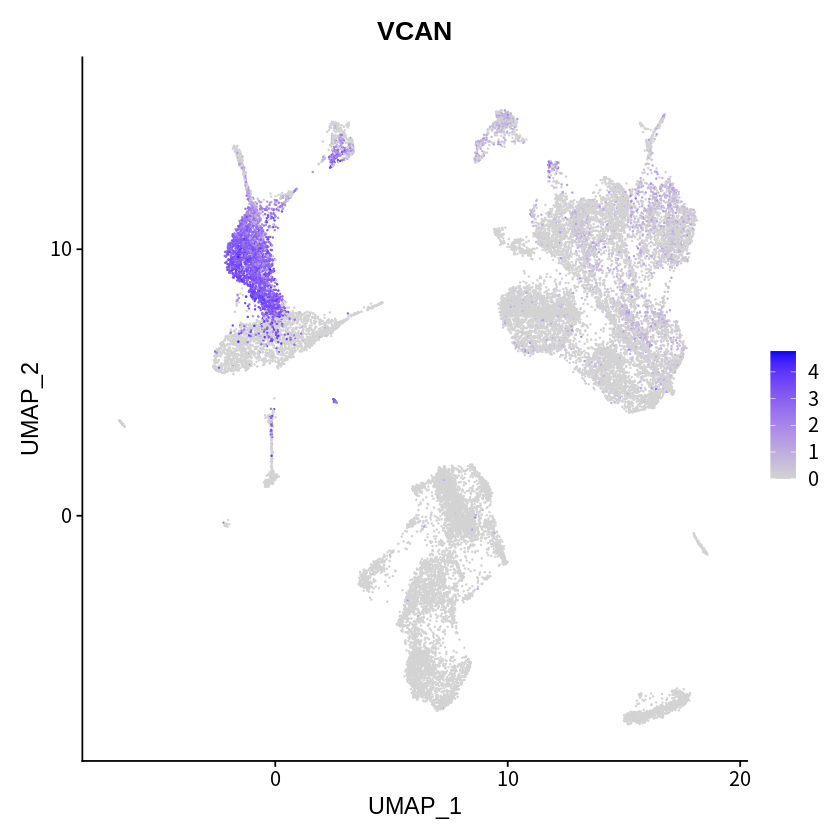

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


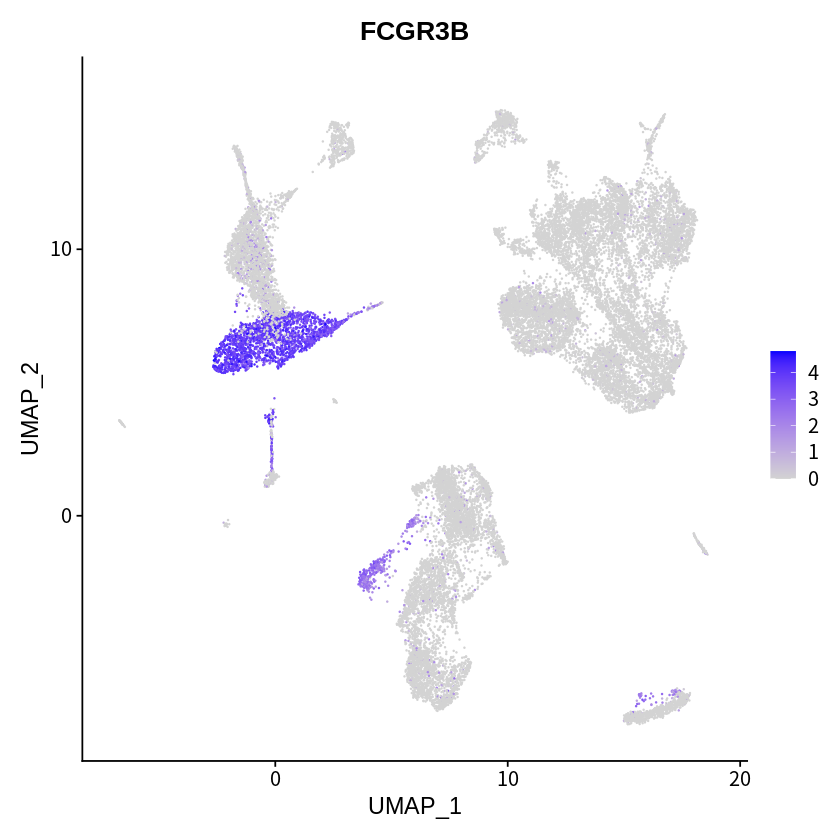

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


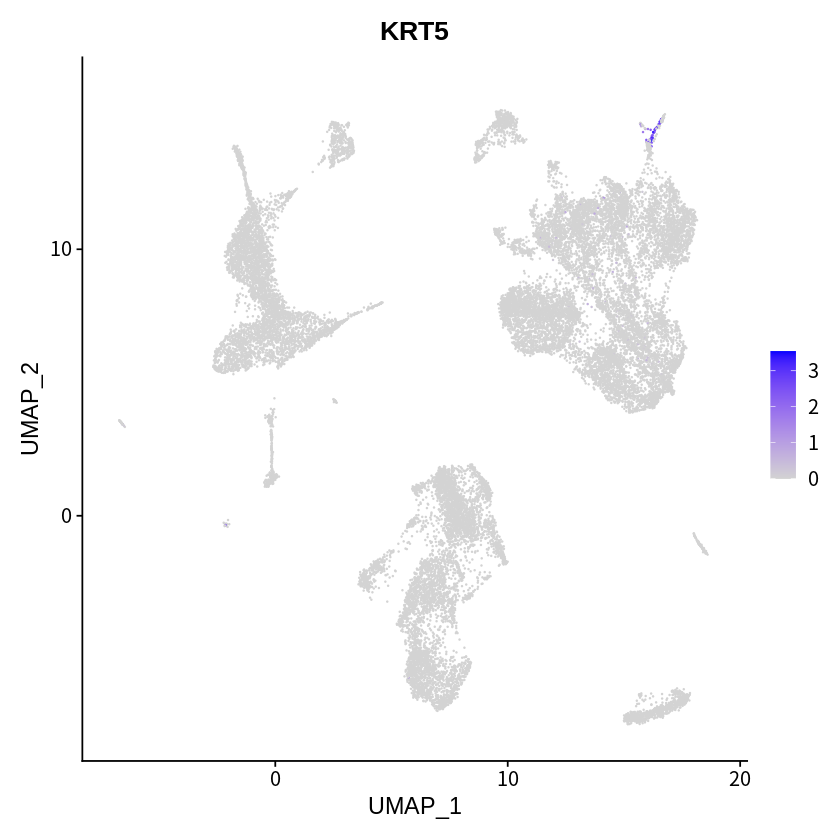

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


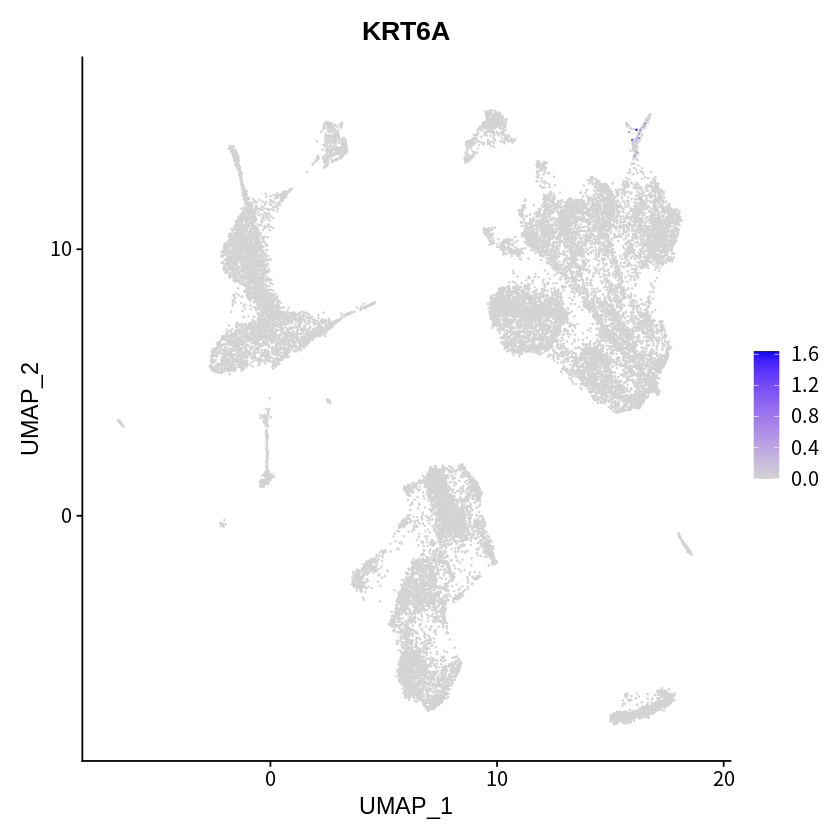

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


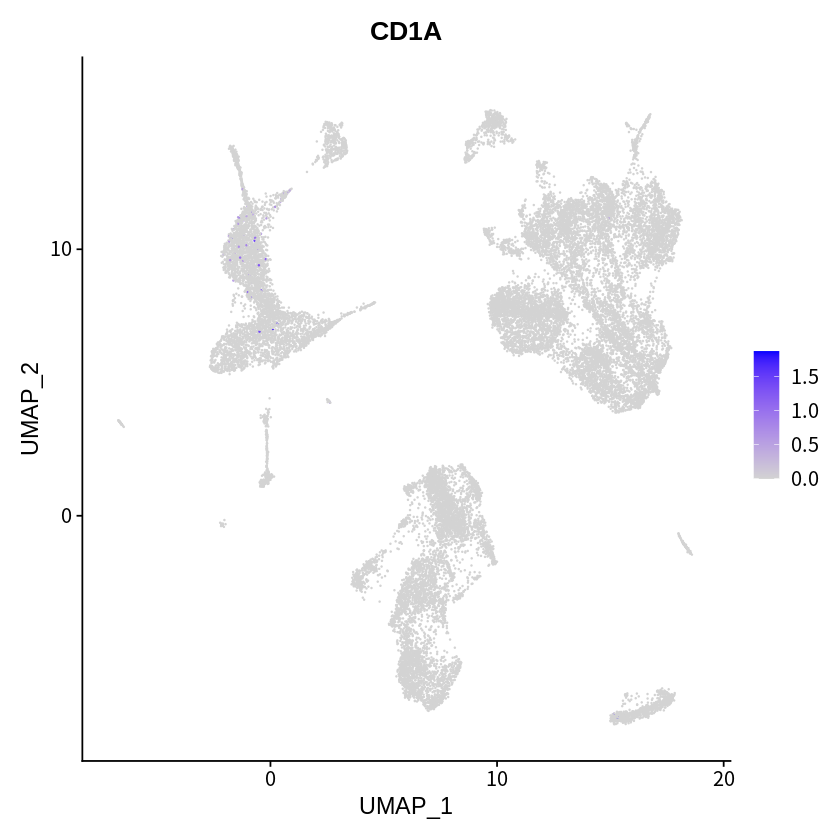

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


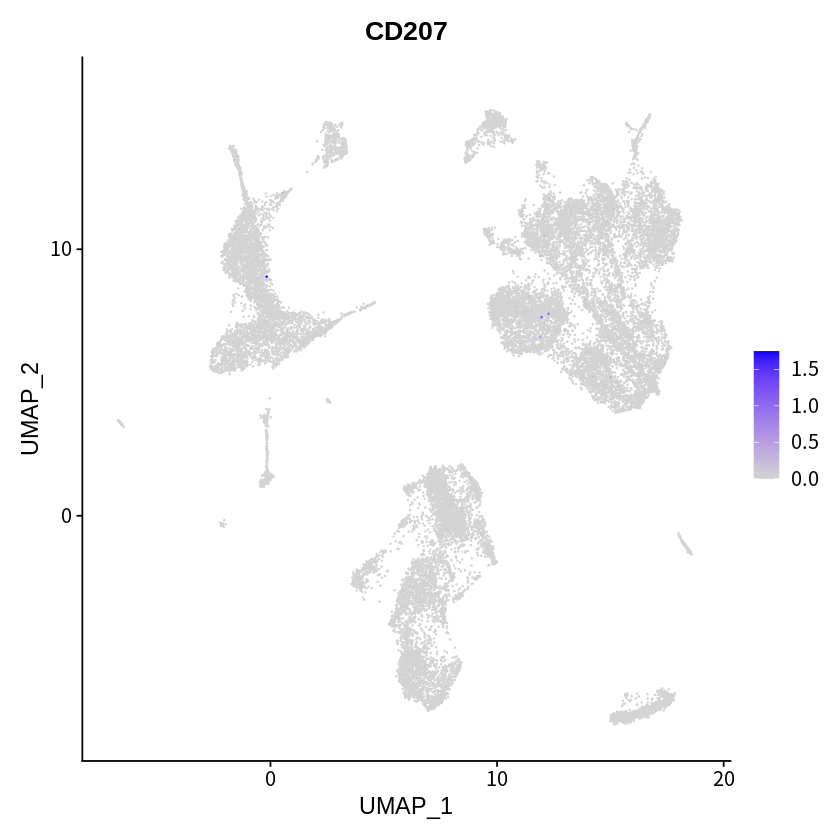

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


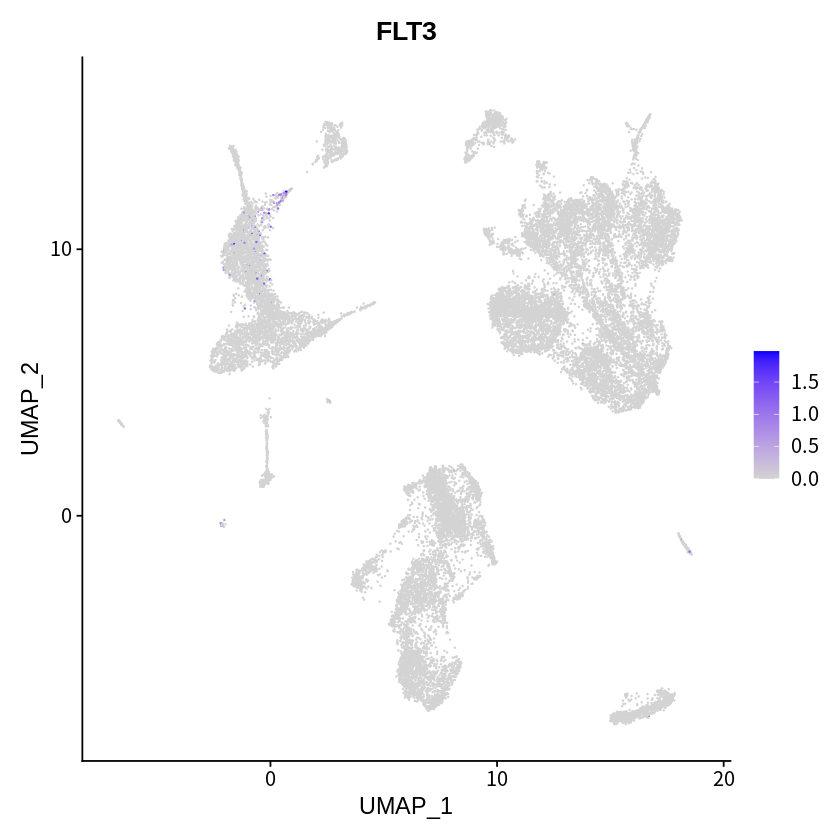

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


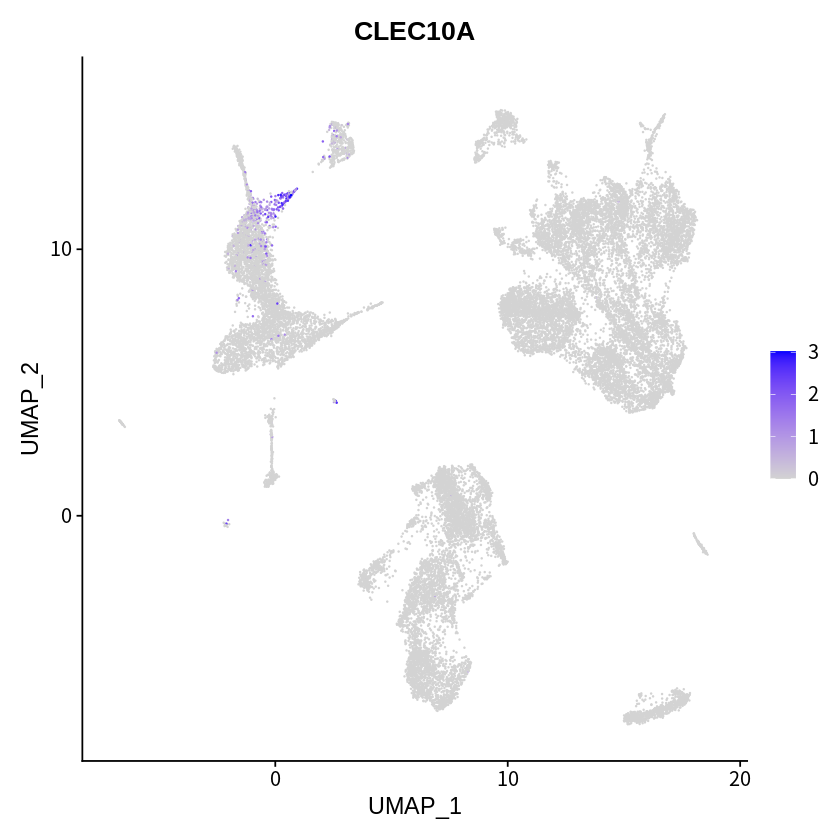

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


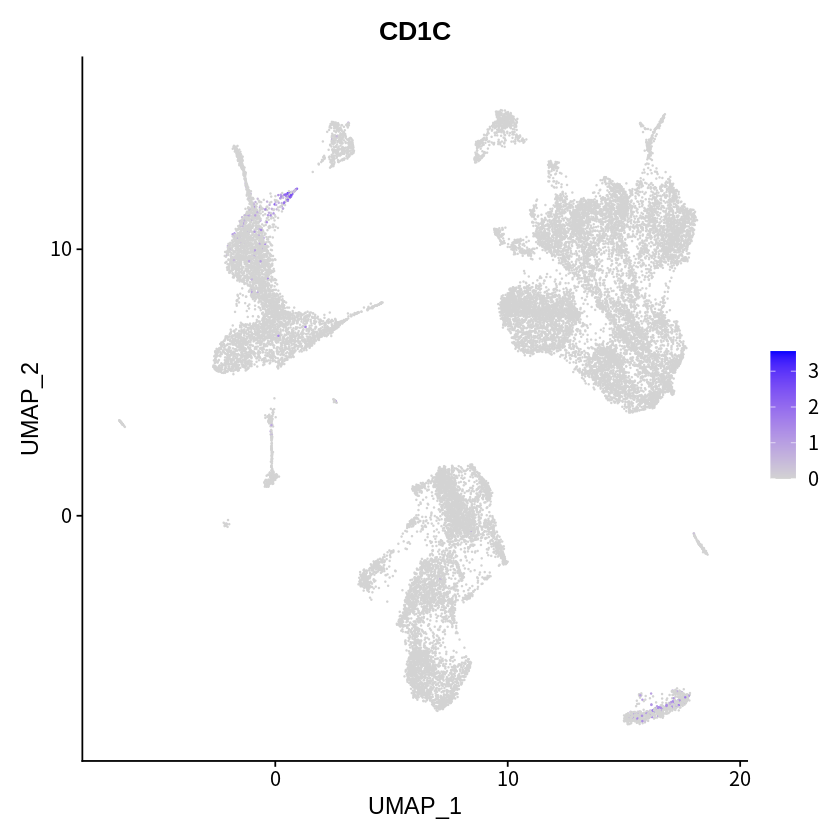

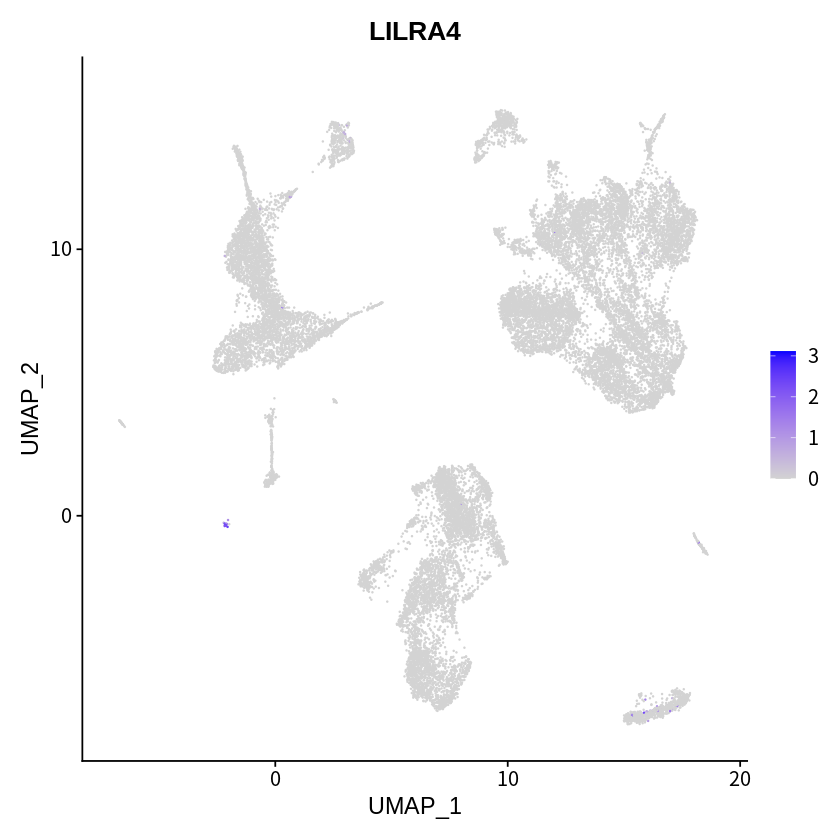

In [12]:
FeaturePlot(SCLC.filter,"EPCAM",sort.cell=F) # tumors
FeaturePlot(SCLC.filter,"CD3E",sort.cell=F) # T cell
FeaturePlot(SCLC.filter,"GNLY",sort.cell=F) # Nk
FeaturePlot(SCLC.filter,"CD79A",sort.cell=F) # B/plasma

FeaturePlot(SCLC.filter,"LYZ",sort.cell=F) # mon/macro
FeaturePlot(SCLC.filter,"CD68",sort.cell=F) # macro
FeaturePlot(SCLC.filter,"PPBP",sort.cell=F) # Megakaryocytes
FeaturePlot(SCLC.filter,"CD4",sort.cell=F) # cd4 t
FeaturePlot(SCLC.filter,"CD8A",sort.cell=F)# cd8 t
# FeaturePlot(SCLC.filter,"CD8B",sort.cell=F)

FeaturePlot(SCLC.filter,"VCAN",sort.cell=F) # monocyte
# FeaturePlot(SCLC.filter,"FCN1",sort.cell=F)
FeaturePlot(SCLC.filter,"FCGR3B",sort.cell=F) #  neutrophil
# FeaturePlot(SCLC.filter,"LAMP3",sort.cell=F)

# check 
FeaturePlot(SCLC.filter,"KRT5",sort.cell=F) # basal
FeaturePlot(SCLC.filter,"KRT6A",sort.cell=F) #

# check DC markers
FeaturePlot(SCLC.filter,"CD1A",sort.cell=F) 
FeaturePlot(SCLC.filter,"CD207",sort.cell=F) 
FeaturePlot(SCLC.filter,"FLT3",sort.cell=F) 
FeaturePlot(SCLC.filter,"CLEC10A",sort.cell=F) 
FeaturePlot(SCLC.filter,"CD1C",sort.cell=F) 
FeaturePlot(SCLC.filter,"LILRA4",sort.cell=F) # pdc


Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”
Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


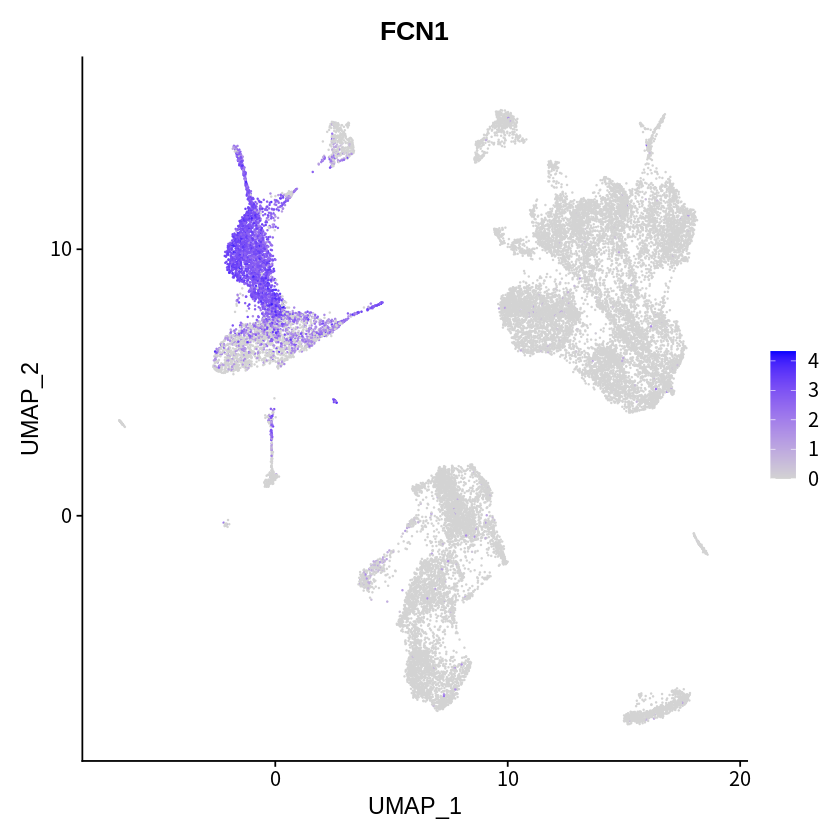

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


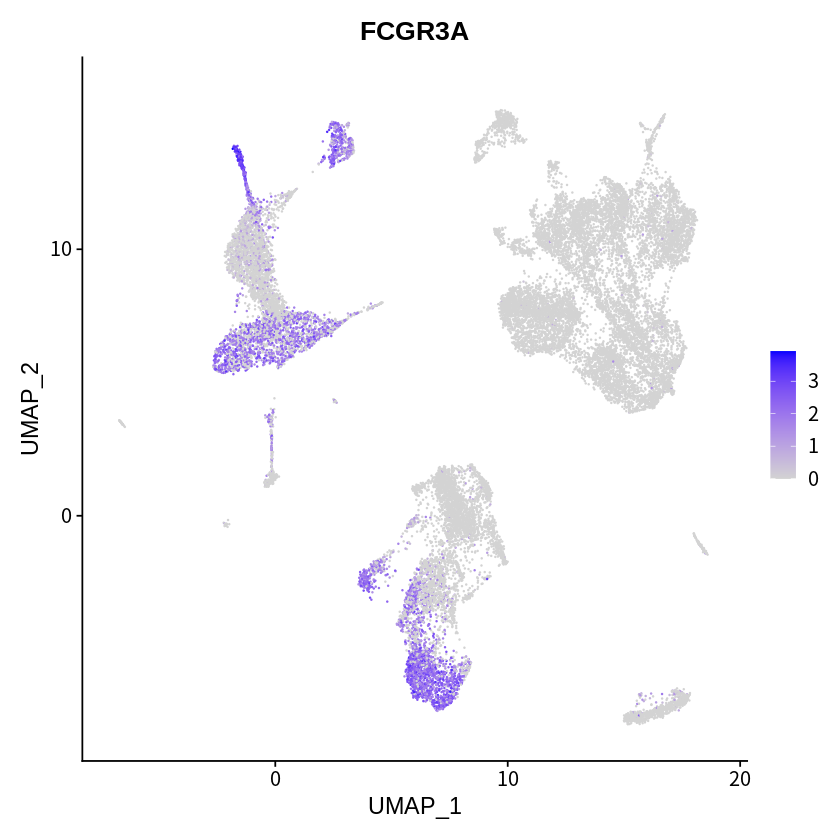

Warning message:
“The sort.cell parameter is being deprecated. Please use the order parameter instead for equivalent functionality.”


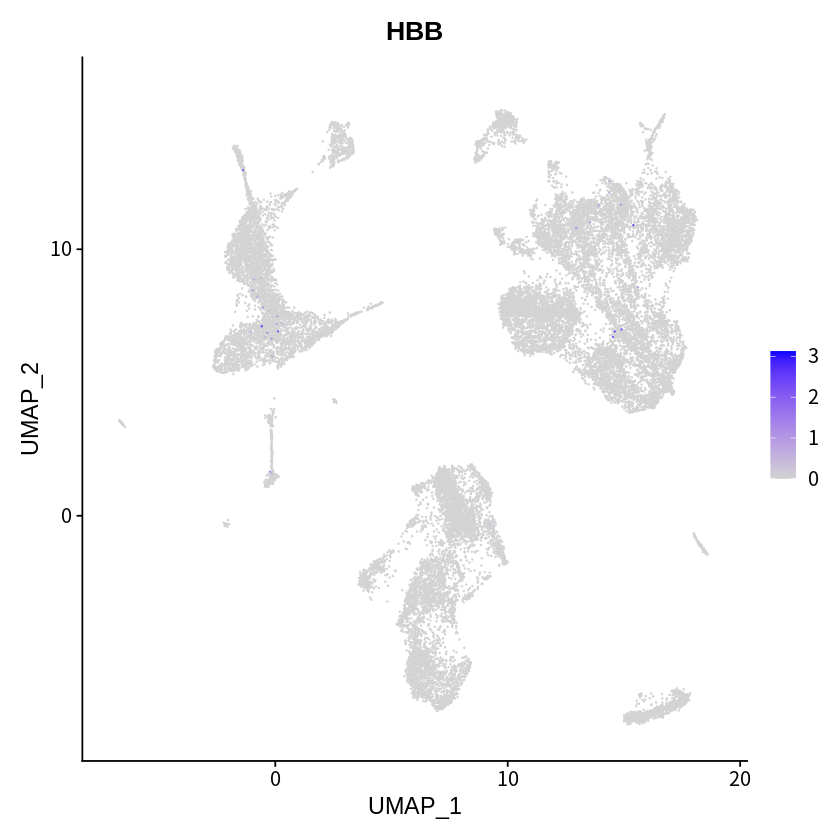

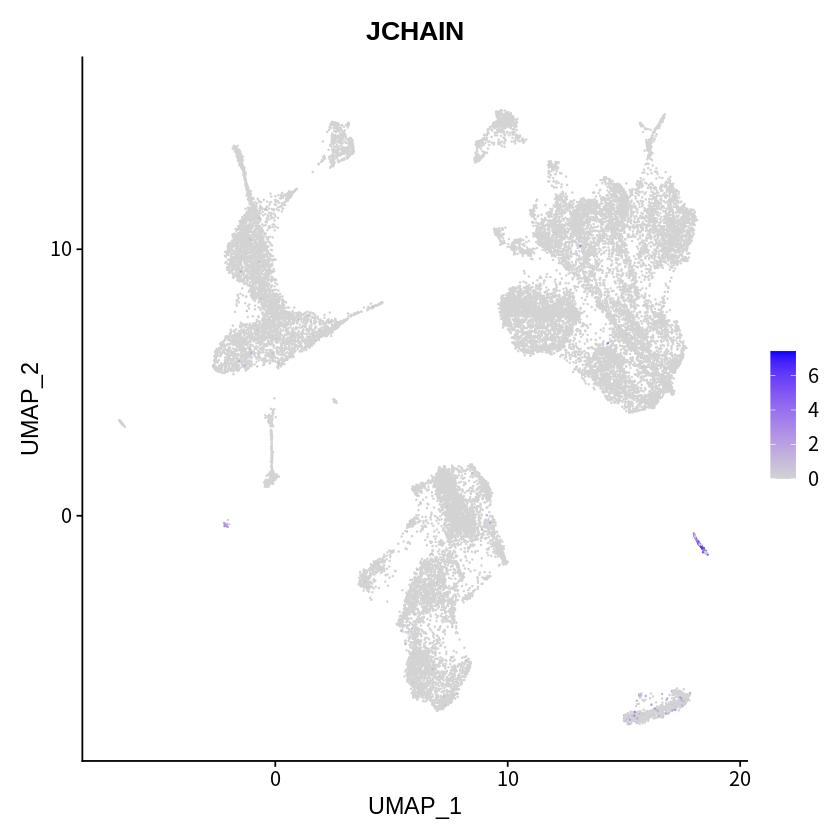

In [13]:
FeaturePlot(SCLC.filter,"FCN1",sort.cell=F) # 
FeaturePlot(SCLC.filter,"FCGR3A",sort.cell=F) # 
FeaturePlot(SCLC.filter,"HBB",sort.cell=F) # 
FeaturePlot(SCLC.filter,"JCHAIN",sort.cell=F) # 


### check fibro and MYOFIRO genes 
ggsave(FeaturePlot(SCLC.filter, "COL3A1", reduction = "umap"), file = "plot/02/COL3A1_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "COL1A1", reduction = "umap"), file = "plot/02/COL1A1_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "COL13A1", reduction = "umap"), file = "plot/02/COL13A1_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "COL14A1", reduction = "umap"), file = "plot/02/COL14A1_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "MYH11", reduction = "umap"), file = "plot/02/MYH11_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "ACTA2", reduction = "umap"), file = "plot/02/ACTA2_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "TAGLN", reduction = "umap"), file = "plot/02/TAGLN_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "ACTG2", reduction = "umap"), file = "plot/02/ACTG2_exp.pdf", width = 5, height = 5)
ggsave(FeaturePlot(SCLC.filter, "MYLK", reduction = "umap"), file = "plot/02/MYLK_exp.pdf", width = 5, height = 5)

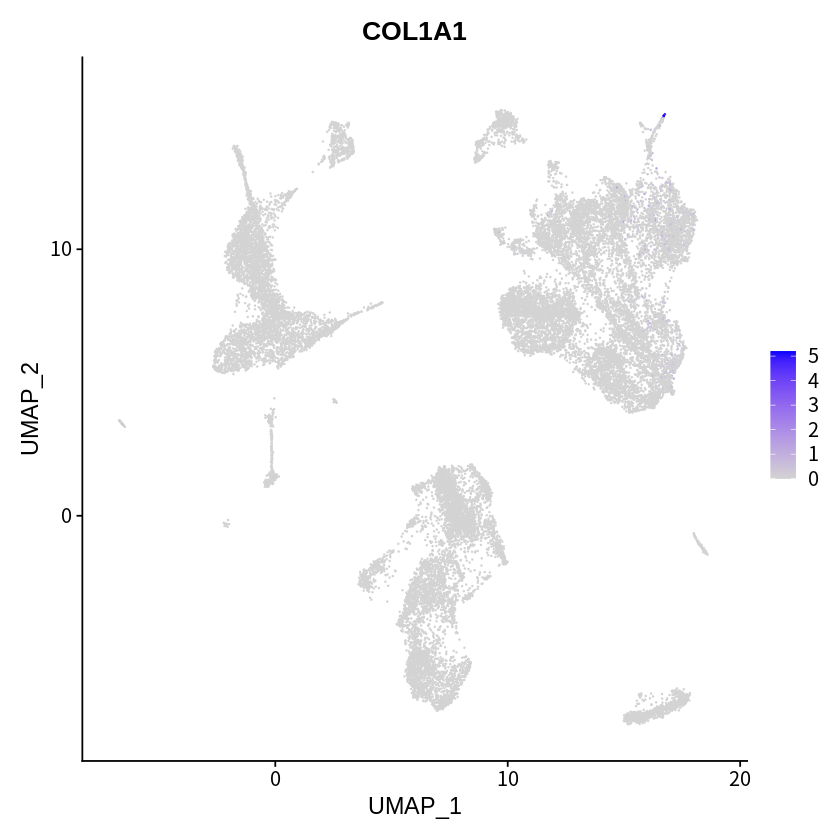

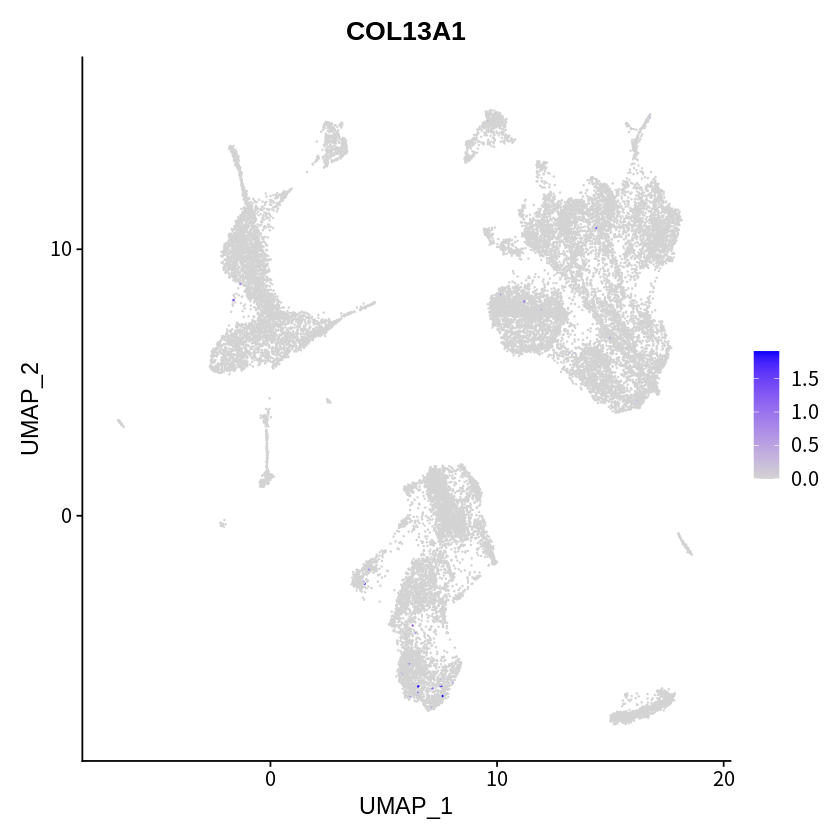

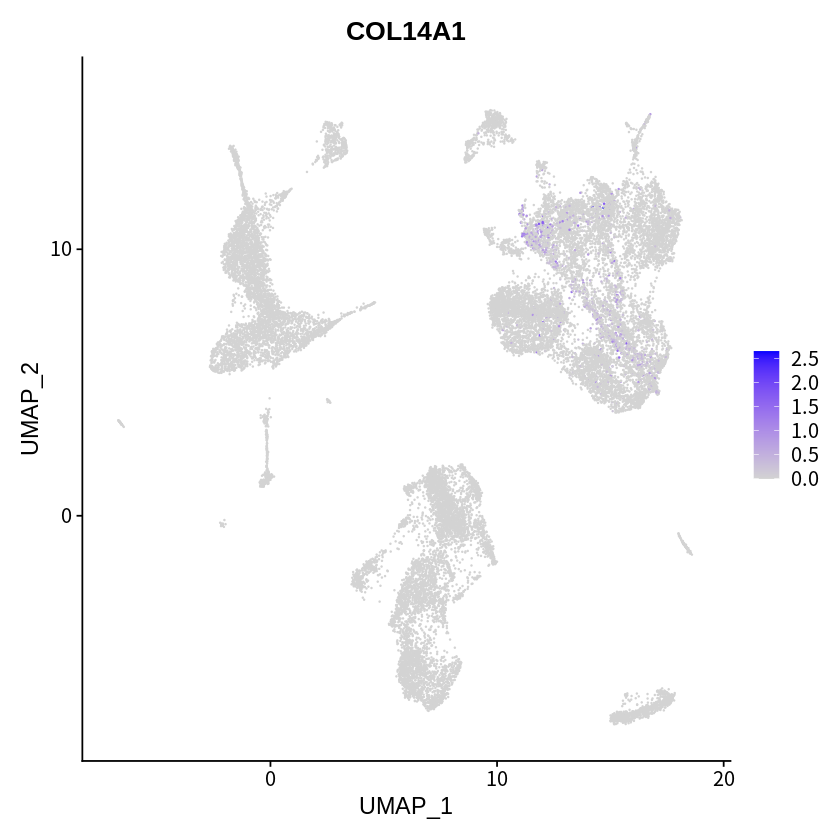

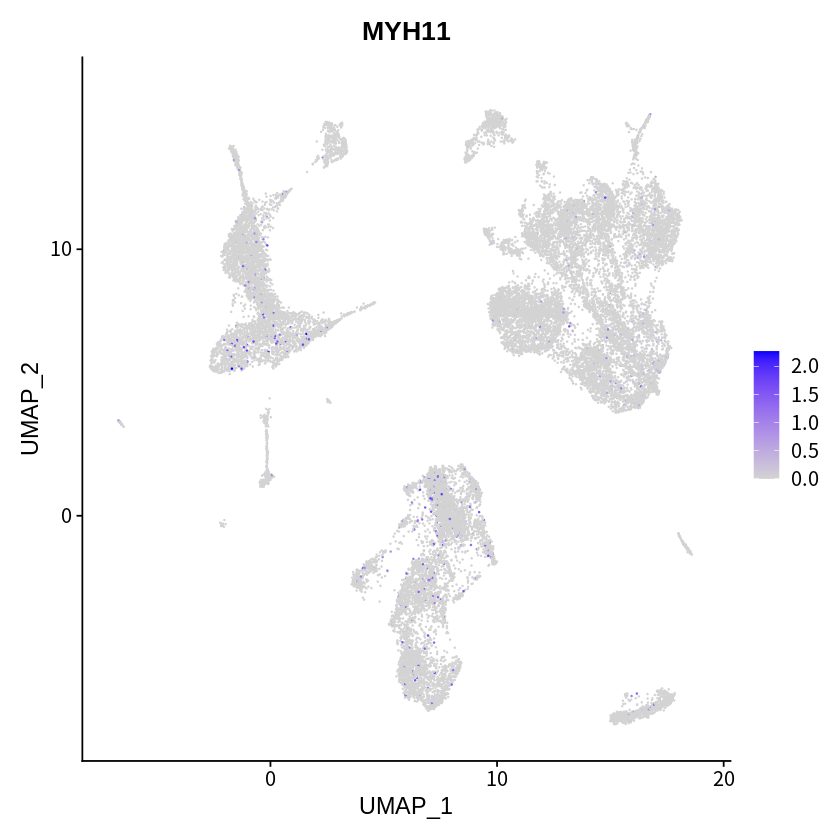

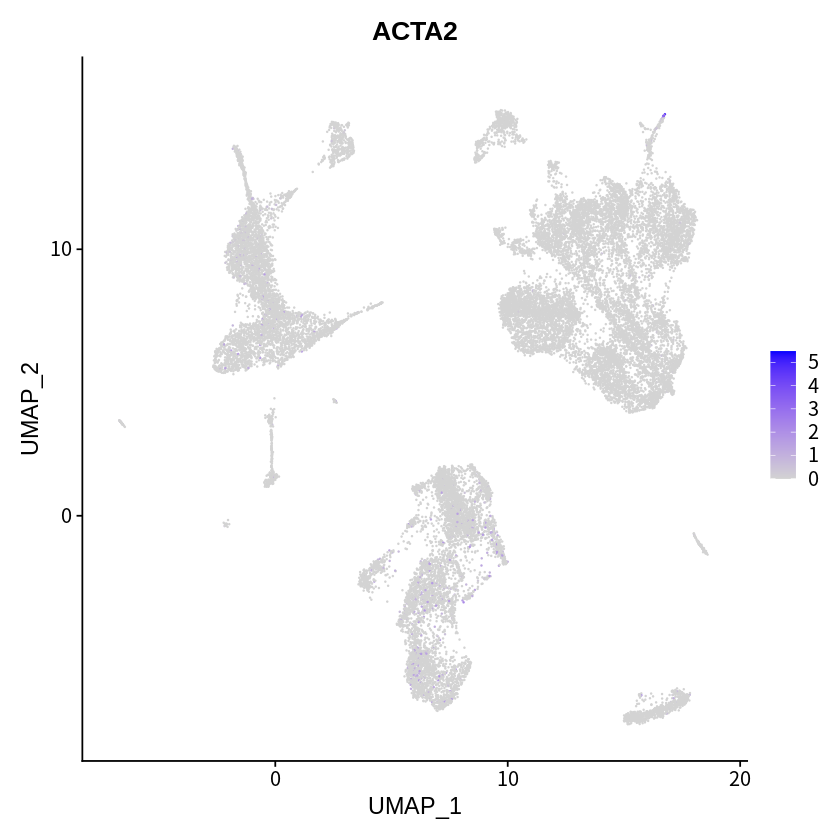

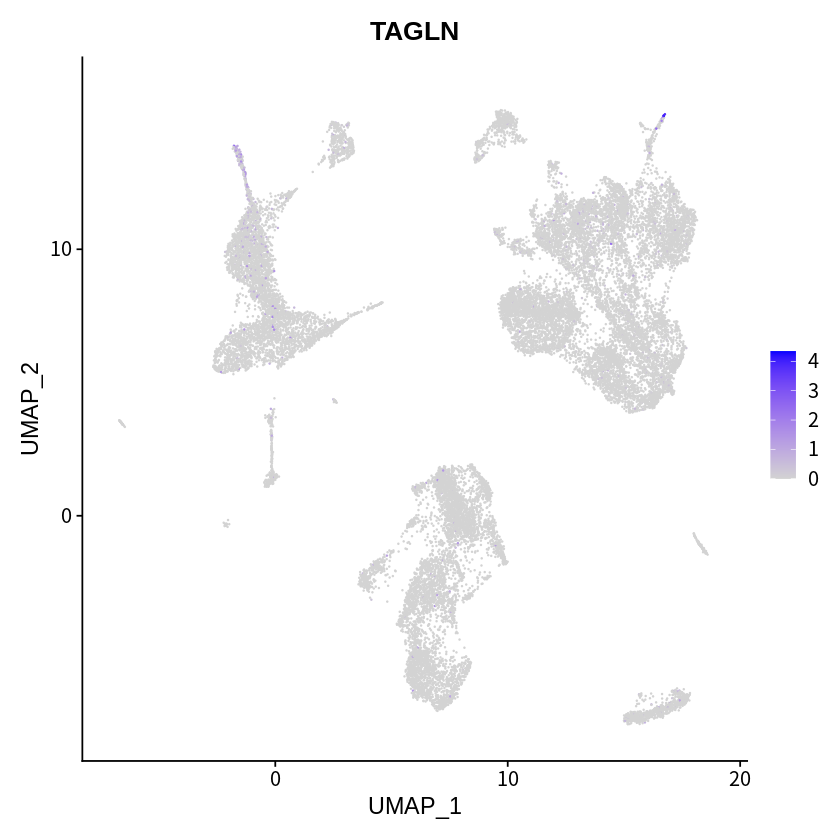

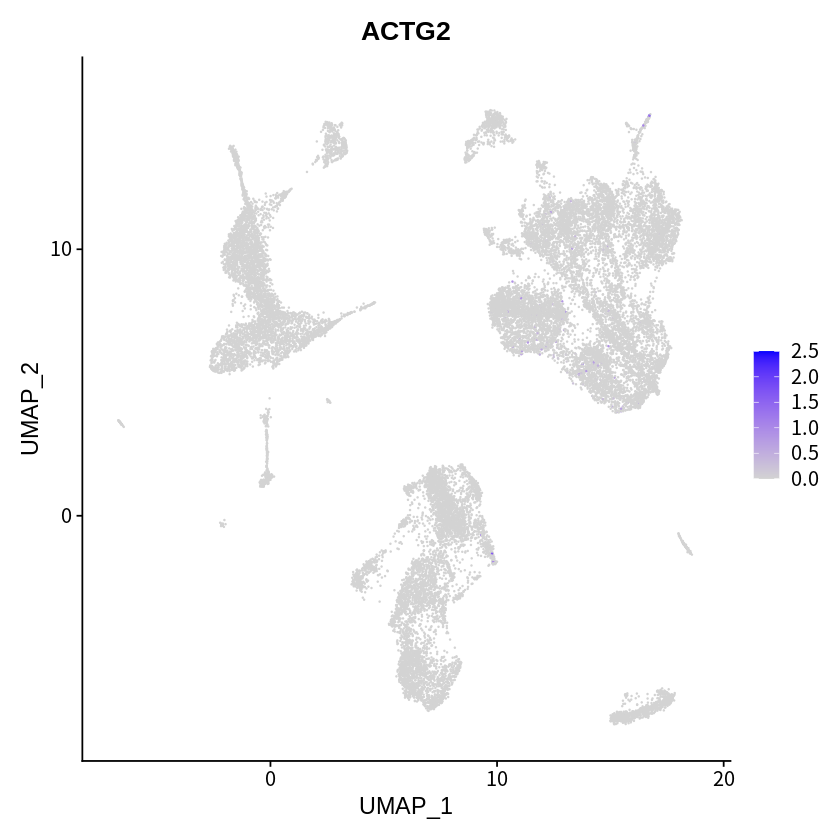

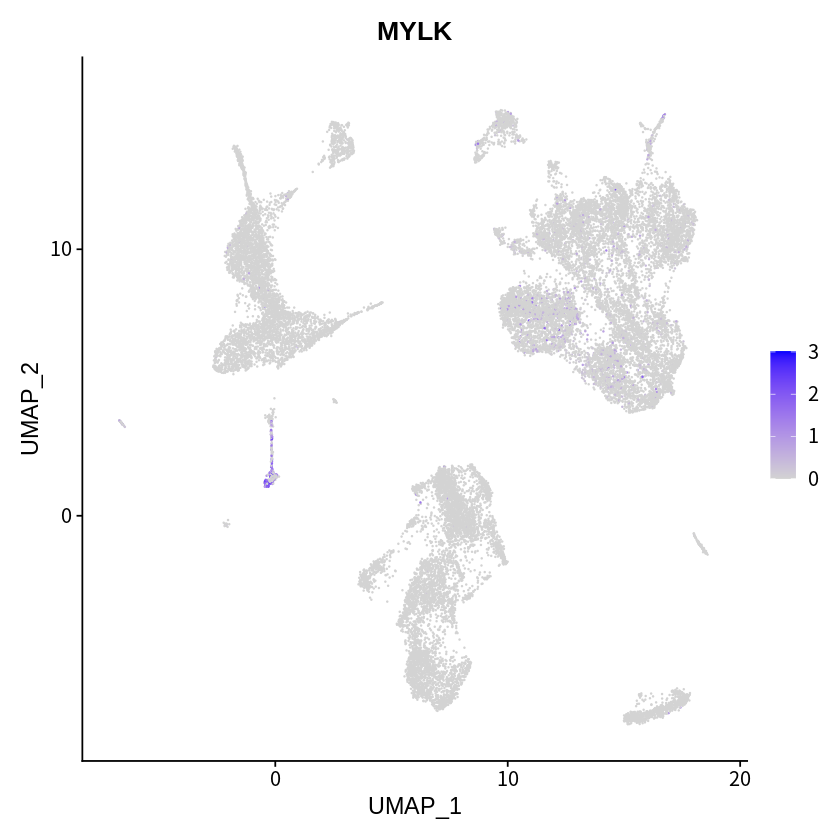

In [10]:
# check fibro and MYOFIRO genes 
FeaturePlot(SCLC.filter, "COL1A1", reduction = "umap")
FeaturePlot(SCLC.filter, "COL13A1", reduction = "umap")
FeaturePlot(SCLC.filter, "COL14A1", reduction = "umap")

FeaturePlot(SCLC.filter, "MYH11", reduction = "umap") #  CAF markers
FeaturePlot(SCLC.filter, "ACTA2", reduction = "umap")
FeaturePlot(SCLC.filter, "TAGLN", reduction = "umap")
FeaturePlot(SCLC.filter, "ACTG2", reduction = "umap")
FeaturePlot(SCLC.filter, "MYLK", reduction = "umap")

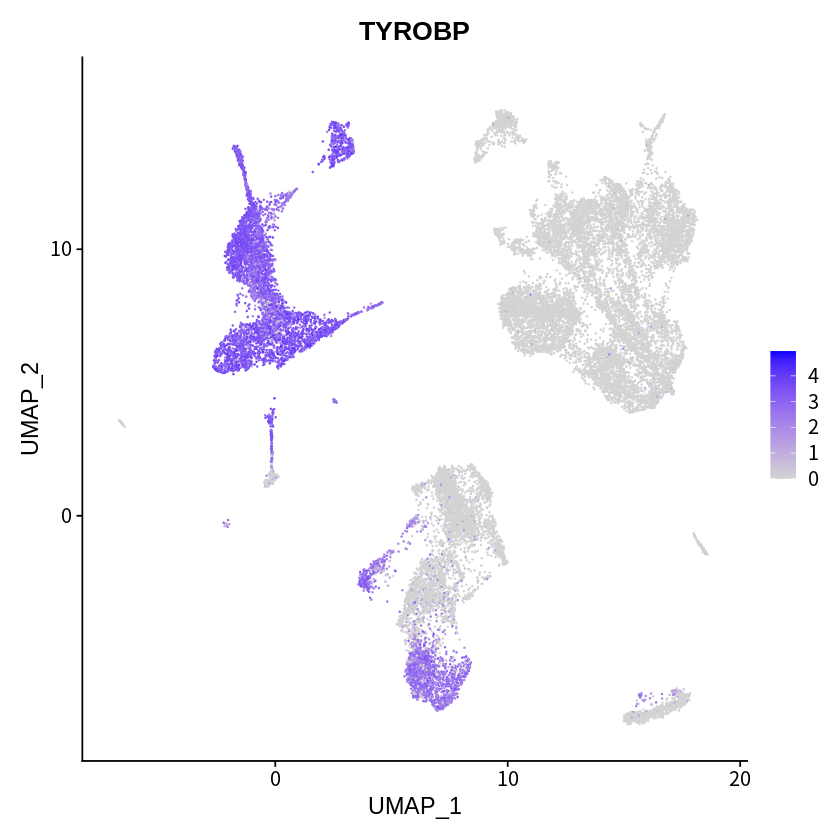

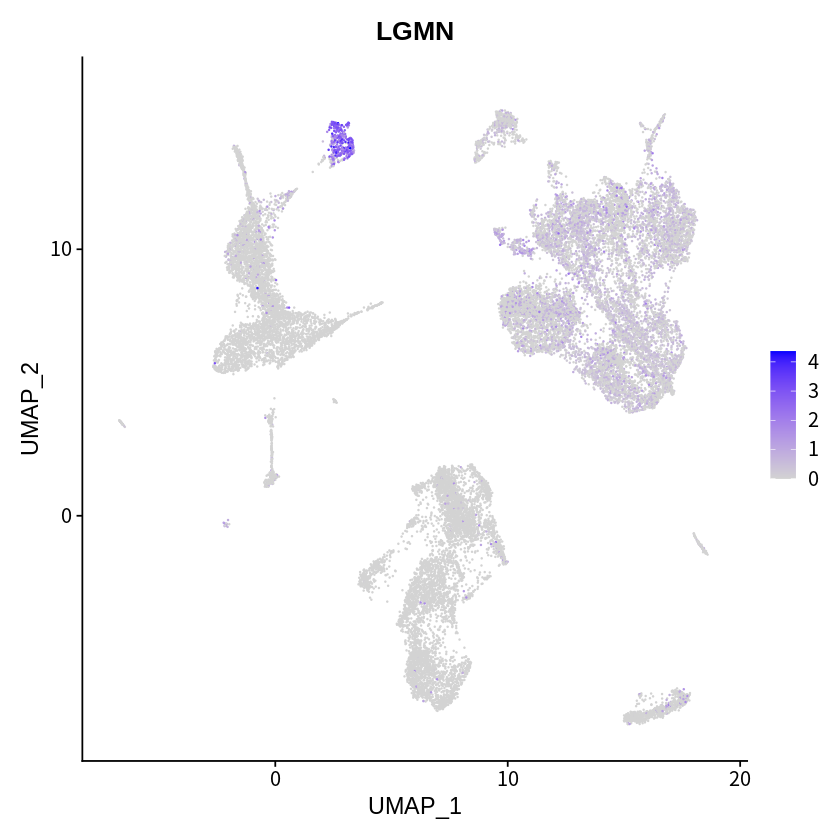

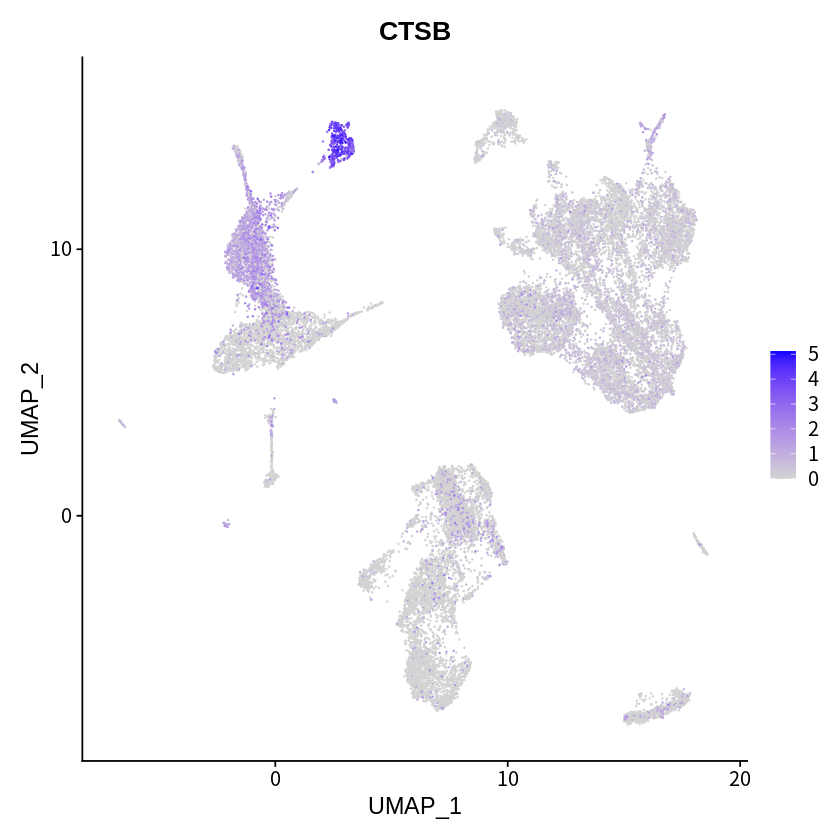

In [18]:
FeaturePlot(SCLC.filter, "TYROBP", reduction = "umap")
FeaturePlot(SCLC.filter, "LGMN", reduction = "umap")
FeaturePlot(SCLC.filter, "CTSB", reduction = "umap")


In [15]:
table(SCLC.filter$seurat_clusters)
SCLC.filter


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2695 2486 2447 1901 1737 1563 1541 1395 1180 1179 1017  798  778  494  412  383 
  16   17   18   19   20   21   22   23   24   25   26   27   28 
 378  267  257  235  201  181  126  119  116   87   42   39   27 

An object of class Seurat 
33538 features across 24081 samples within 1 assay 
Active assay: RNA (33538 features, 3000 variable features)
 3 dimensional reductions calculated: pca, umap, harmony

In [19]:
# label
c("tumor",	"tumor",	"Neutrophils",	"Monocytes",	"CD4T",	"tumor",	"NK",	"CD8T",	"tumor",	"tumor",
  "tumor",	"B cells",	"tumor",	"tumor",	"NK",	"CD4T",	"Macrophages",	"CD4T",	"Megakaryocytes",
  "Monocytes",	"tumor",	"tumor",	"DC",	"Plasma",	"CD8T",	"tumor",	"tumor",	"DC",	"Monocytes") -> new_label

In [20]:
names(new_label) <- levels(SCLC.filter)
SCLC.filter <- RenameIdents(SCLC.filter, new_label)

In [21]:
Idents(SCLC.filter) <- factor(Idents(SCLC.filter), 
       levels = c("tumor", "CD4T","Monocytes","Neutrophils","CD8T","NK","B cells","Megakaryocytes","Macrophages","DC", "Plasma"))
SCLC.filter[["celltype"]]<-Idents(SCLC.filter)

In [22]:
table(Idents(SCLC.filter)); table(SCLC.filter$celltype); unique(SCLC.filter$celltype)


         tumor           CD4T      Monocytes    Neutrophils           CD8T 
         11903           2387           2163           2447           1511 
            NK        B cells Megakaryocytes    Macrophages             DC 
          1953            798            257            378            165 
        Plasma 
           119 


         tumor           CD4T      Monocytes    Neutrophils           CD8T 
         11903           2387           2163           2447           1511 
            NK        B cells Megakaryocytes    Macrophages             DC 
          1953            798            257            378            165 
        Plasma 
           119 

[1] tumor          CD8T           NK             CD4T           Macrophages   
 [6] Neutrophils    B cells        Monocytes      Megakaryocytes DC            
[11] Plasma        
11 Levels: tumor CD4T Monocytes Neutrophils CD8T NK B cells ... Plasma

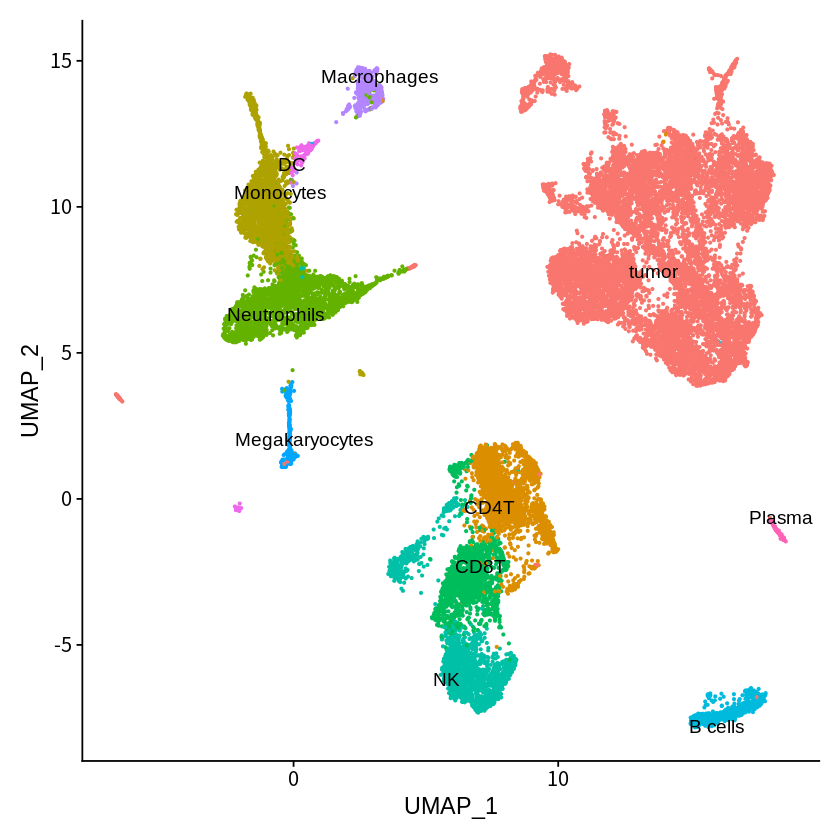

In [23]:
DimPlot(SCLC.filter, reduction = "umap", repel=T,label = T, pt.size = 0.5) + NoLegend()
DimPlot(SCLC.filter, reduction = "umap", repel=F,label = TRUE, pt.size = 0.5) ->xxxx

In [24]:
table(SCLC.filter$orig.ident, SCLC.filter$celltype)

    
     tumor CD4T Monocytes Neutrophils CD8T   NK B cells Megakaryocytes
  S1  1587   89        63          19   88   71      12              2
  S2  2601  155       475         278  107  208      68             10
  S3    38  407      1018        1920  614 1165     345            184
  S4  2330   93       117          47   25   24      34             35
  S5    74  832       310         107  390  202      26             17
  S6  4896  520       138          61  211  237     115              7
  S7   377  291        42          15   76   46     198              2
    
     Macrophages   DC Plasma
  S1          12    4      2
  S2          58   17     15
  S3          11   35     25
  S4          20    9      4
  S5          24   67     26
  S6         120   27     29
  S7         133    6     18

In [25]:
table(SCLC.filter@meta.data[,"orig.ident"],SCLC.filter@meta.data[,"celltype"])->cell_stat
# cell_stat <- cell_stat[,c('tumor','CD4T','Monocytes','Neutrophils','CD8T','NK','B cells','Megakaryocytes','Macrophages','DC','Plasma')]
cell_stat/rowSums(cell_stat)-> cell_stat2

unique(ggplot_build(xxxx)$data[[1]][,c("group","colour")])->color_list
color_list2<-color_list[order(color_list[,1]),2]

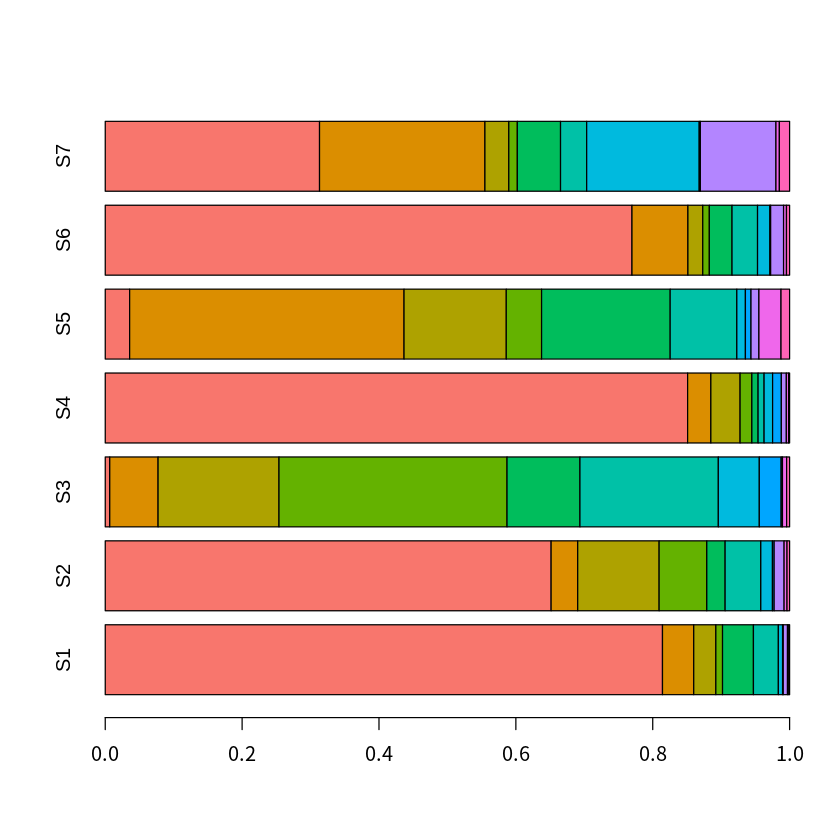

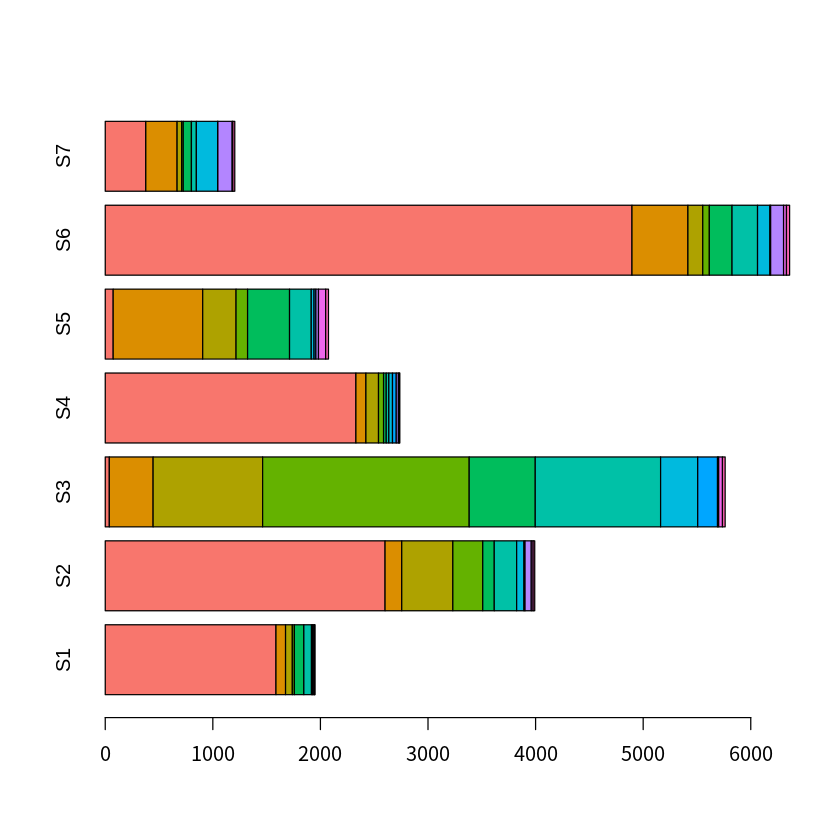

In [26]:
barplot(t(cell_stat2),col= color_list2,horiz =T,width=0.8)

barplot(t(cell_stat),col= color_list2,horiz =T,width=0.8)
data.frame(tumor=as.vector(cell_stat[,"tumor"]), myeloid=as.vector(rowSums(cell_stat[,c("Monocytes","Neutrophils","Macrophages","DC")])),B=as.vector(rowSums(cell_stat[,c("B cells","Plasma")])),leu=as.vector(rowSums(cell_stat[,c("CD8T","NK","CD4T")])), Megakaryocytes =as.vector(cell_stat[,"Megakaryocytes"]))->cells_counts

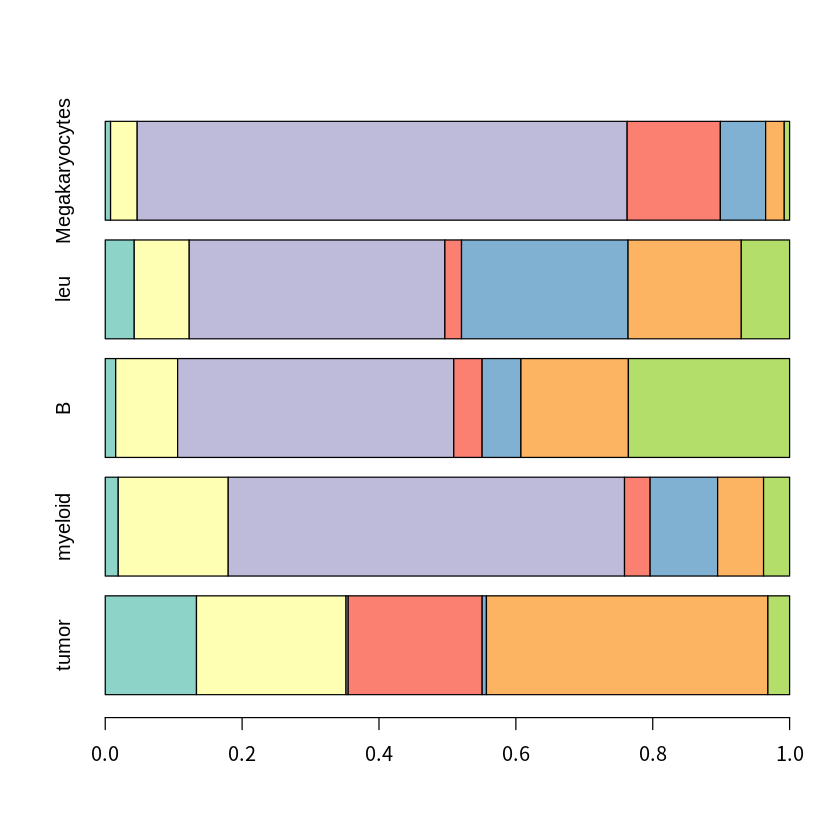

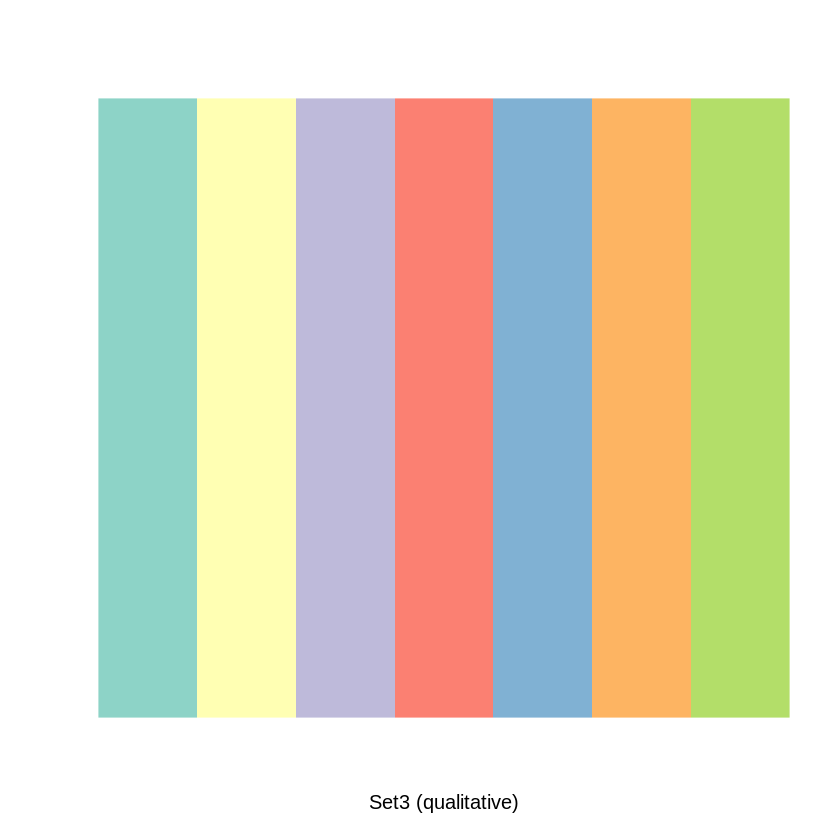

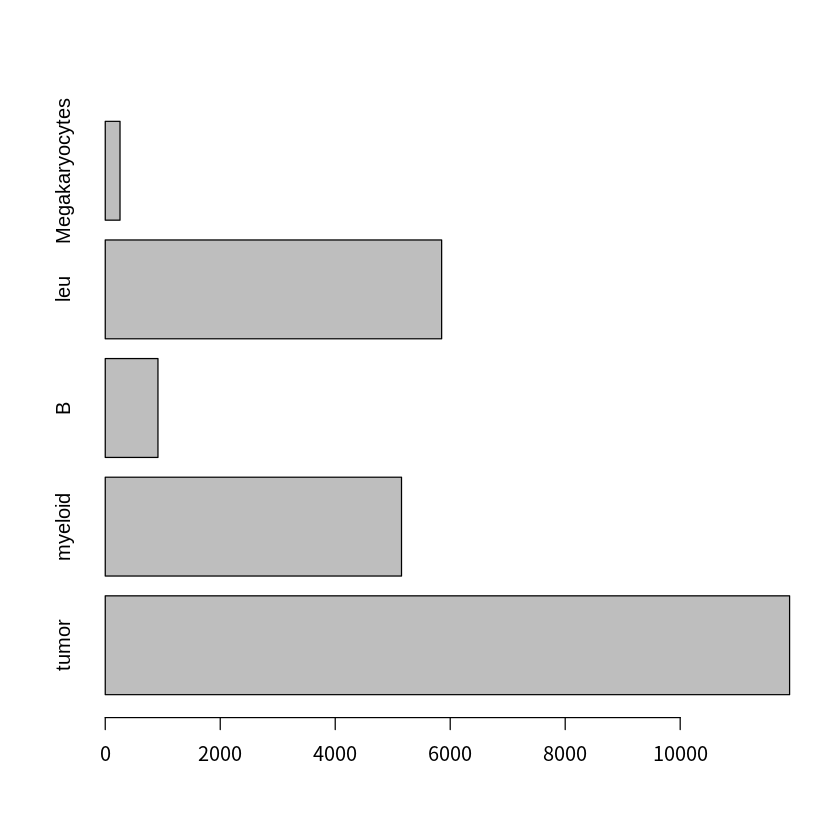

In [27]:
library(RColorBrewer)
barplot(t(t(cells_counts)/colSums(cells_counts)), horiz=T,col= brewer.pal(n = 7, name = "Set3"))
display.brewer.pal(n = 7, name = 'Set3')

barplot(colSums(cells_counts), horiz=T)

In [28]:
cell_stat2

    
           tumor        CD4T   Monocytes Neutrophils        CD8T          NK
  S1 0.814263725 0.045664443 0.032324269 0.009748589 0.045151360 0.036428938
  S2 0.651553106 0.038827655 0.118987976 0.069639279 0.026803607 0.052104208
  S3 0.006594932 0.070635196 0.176674766 0.333217633 0.106560222 0.202186741
  S4 0.850986121 0.033966399 0.042731921 0.017165814 0.009130752 0.008765522
  S5 0.035662651 0.400963855 0.149397590 0.051566265 0.187951807 0.097349398
  S6 0.769690300 0.081748153 0.021694702 0.009589687 0.033170885 0.037258293
  S7 0.313122924 0.241694352 0.034883721 0.012458472 0.063122924 0.038205980
    
         B cells Megakaryocytes Macrophages          DC      Plasma
  S1 0.006157004    0.001026167 0.006157004 0.002052335 0.001026167
  S2 0.017034068    0.002505010 0.014529058 0.004258517 0.003757515
  S3 0.059875043    0.031933356 0.001909059 0.006074280 0.004338771
  S4 0.012417823    0.012783053 0.007304602 0.003287071 0.001460920
  S5 0.012530120    0.008192771 0.

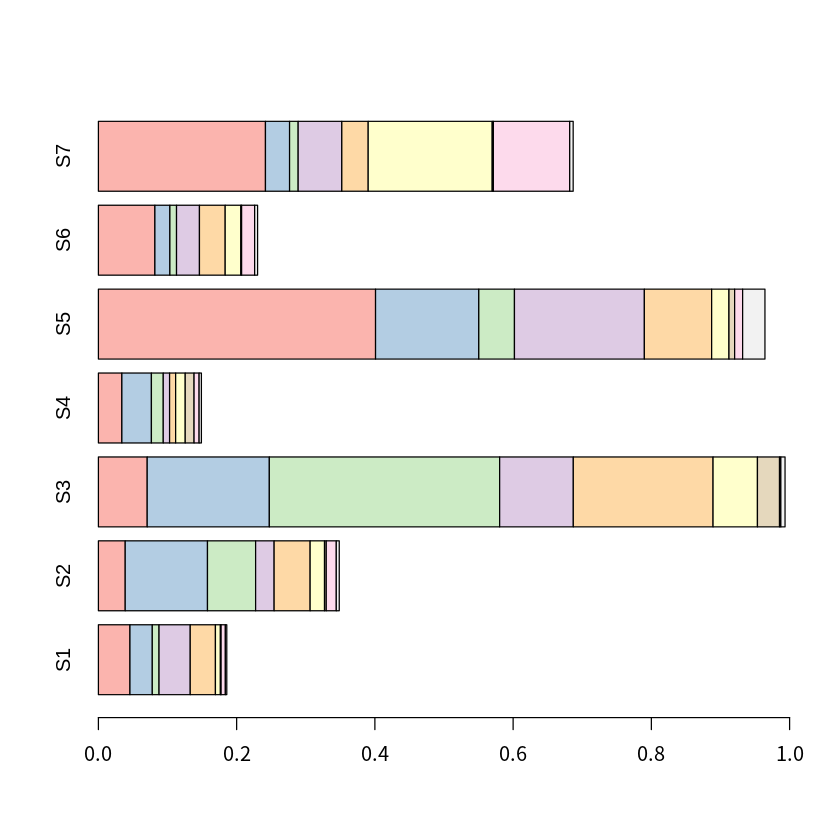

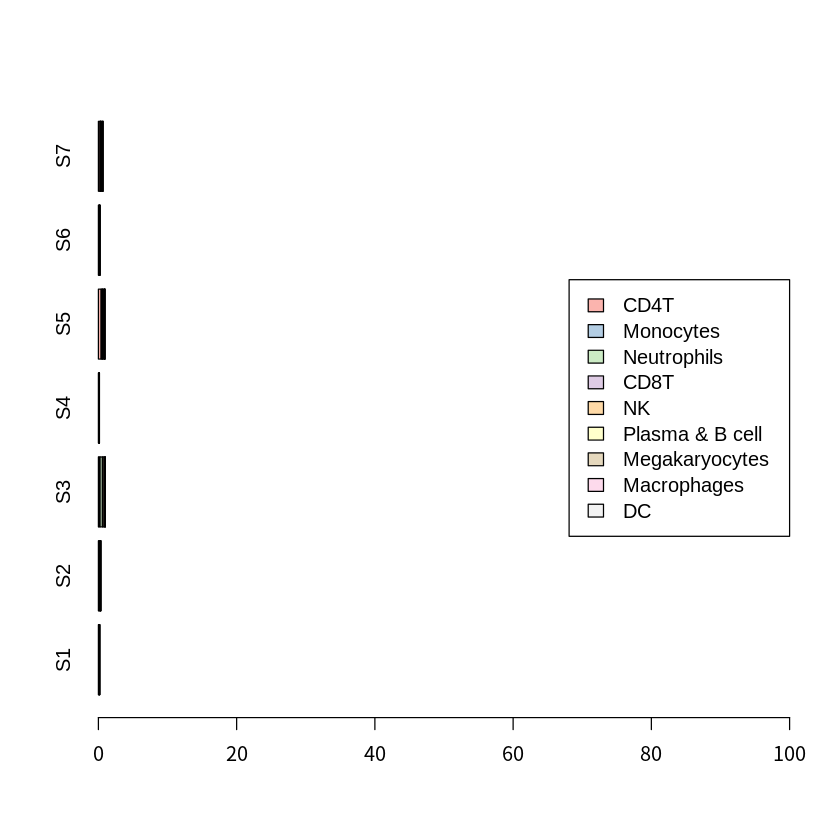

In [29]:
cbind(cell_stat2[,1:6],rowSums(cell_stat2[,c("B cells","Plasma")]),cell_stat2[,c(8:10)])-> cell_stat3
colnames(cell_stat3)[7]<-"Plasma & B cell"

barplot(t(cell_stat3[,-1]),col=brewer.pal(n = 9, name = "Pastel1"),horiz=T,xlim=c(0,1))
barplot(t(cell_stat3[,-1]),col=brewer.pal(n = 9, name = "Pastel1"),horiz=T,xlim=c(0,100), legend=T, args.legend = list(x = "right"))

In [30]:
####  load mutation data 
read.csv("data_input/mutation_counts_sample.csv",row.names=1,header=T)->mutation_counts
t(mutation_counts)[1,]-> mutation_counts

cor_S3=c()
cor_S3_no=c()

In [33]:
mutation_counts
cell_stat3
mutation_counts[names(immune_infiltration)]

S5_tumor S2_tumor S1_tumor S7_tumor S4_tumor S6_tumor S3_tumor 
     393      330      236      224      172      121        7

tumor       CD4T       Monocytes  Neutrophils CD8T        NK         
S1 0.814263725 0.04566444 0.03232427 0.009748589 0.045151360 0.036428938
S2 0.651553106 0.03882766 0.11898798 0.069639279 0.026803607 0.052104208
S3 0.006594932 0.07063520 0.17667477 0.333217633 0.106560222 0.202186741
S4 0.850986121 0.03396640 0.04273192 0.017165814 0.009130752 0.008765522
S5 0.035662651 0.40096386 0.14939759 0.051566265 0.187951807 0.097349398
S6 0.769690300 0.08174815 0.02169470 0.009589687 0.033170885 0.037258293
S7 0.313122924 0.24169435 0.03488372 0.012458472 0.063122924 0.038205980
   Plasma & B cell Megakaryocytes Macrophages DC         
S1 0.007183171     0.001026167    0.006157004 0.002052335
S2 0.020791583     0.002505010    0.014529058 0.004258517
S3 0.064213815     0.031933356    0.001909059 0.006074280
S4 0.013878744     0.012783053    0.007304602 0.003287071
S5 0.025060241     0.008192771    0.011566265 0.032289157
S6 0.022637950     0.001100456    0.018864958 0.004244616
S7 0.179401993     0.001661130    0.110465116 0.004983389

S1_tumor S2_tumor S3_tumor S4_tumor S5_tumor S6_tumor S7_tumor 
     236      330        7      172      393      121      224

In [32]:
for( cell in colnames(cell_stat3) )
{
print(cell)
c(cell_stat3[,cell])-> immune_infiltration
names(immune_infiltration)<-paste(names(immune_infiltration),"tumor",sep="_")
#plot(mutation_counts[names(immune_infiltration)][-3], immune_infiltration[-3])
cor(mutation_counts[names(immune_infiltration)][-3], immune_infiltration[-3],method="spearman")->cor1
cor(mutation_counts[names(immune_infiltration)], immune_infiltration,method="spearman")->cor2
cor_S3=c(cor_S3,cor2)
cor_S3_no=c(cor_S3_no,cor1)
}
names(cor_S3)<-names(cor_S3_no)<-colnames(cell_stat3)

[1] "tumor"
[1] "CD4T"
[1] "Monocytes"
[1] "Neutrophils"
[1] "CD8T"
[1] "NK"
[1] "Plasma & B cell"
[1] "Megakaryocytes"
[1] "Macrophages"
[1] "DC"


Warning message in plot.window(...):
“"method" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"method" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"method" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"method" is not a graphical parameter”
Warning message in box(...):
“"method" is not a graphical parameter”
Warning message in title(...):
“"method" is not a graphical parameter”


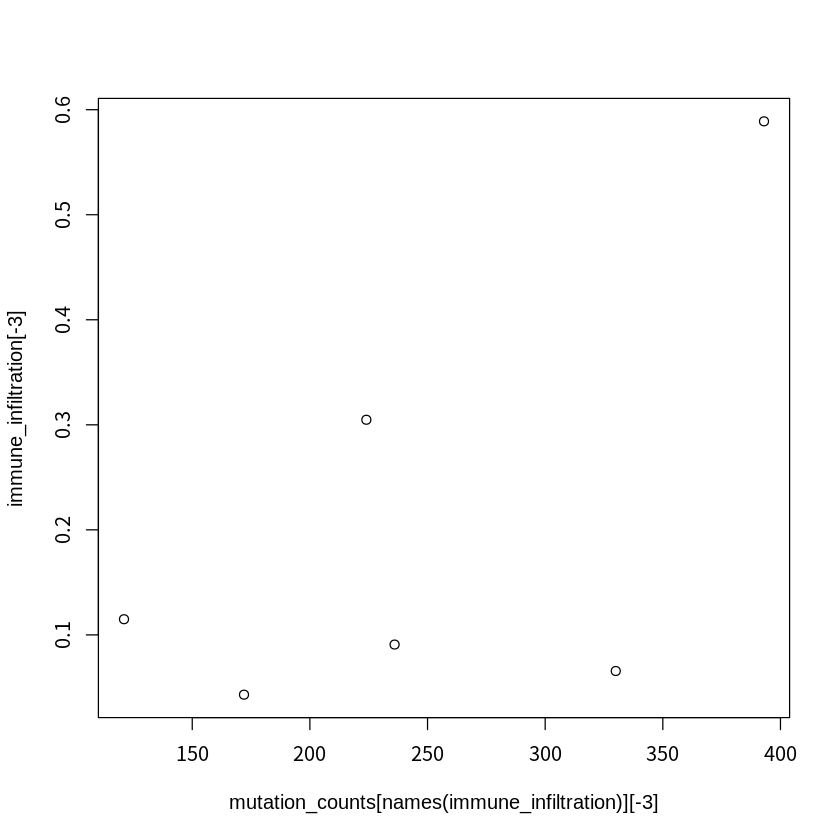

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



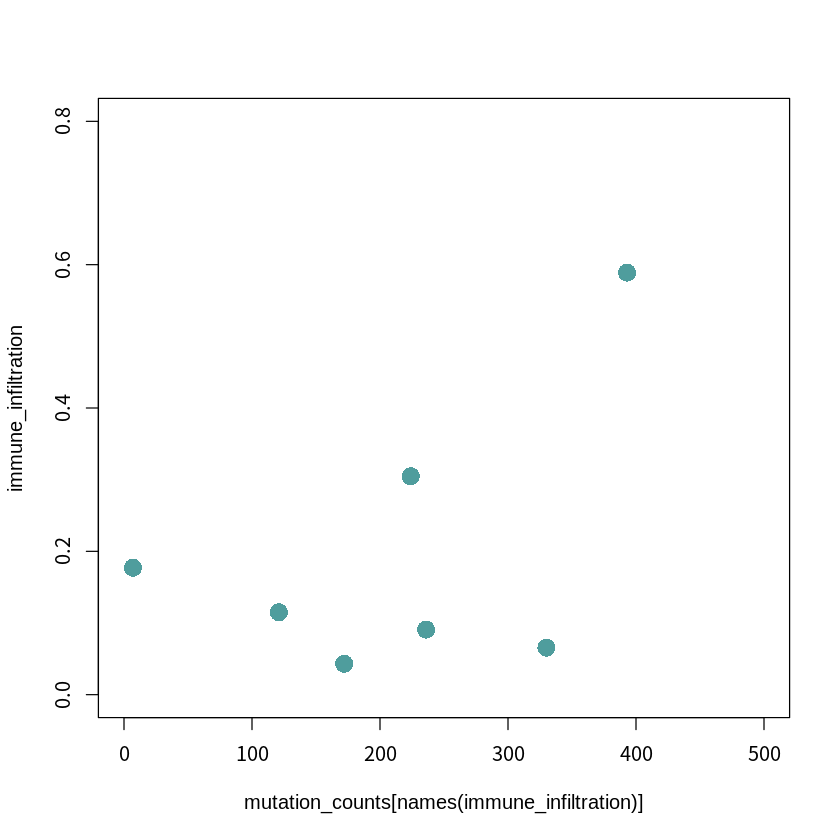

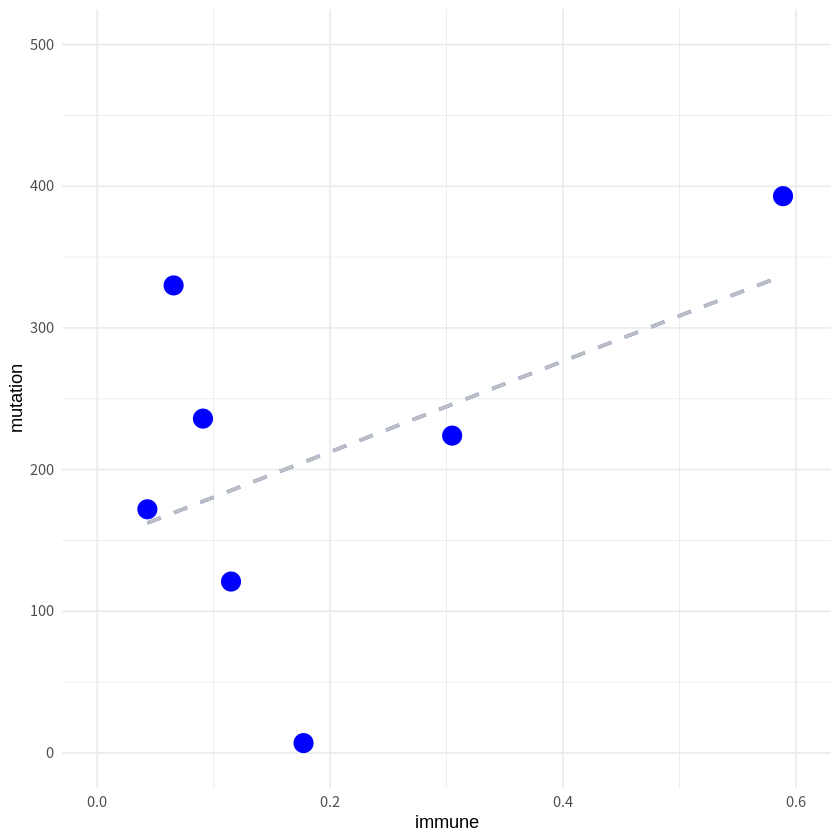

In [34]:
rowSums(cell_stat2[,c("CD4T","CD8T")])-> immune_infiltration
names(immune_infiltration)<-paste(names(immune_infiltration),"tumor",sep="_")
#plot(mutation_counts[names(immune_infiltration)][-3], immune_infiltration[-3])
plot(mutation_counts[names(immune_infiltration)][-3], immune_infiltration[-3],method="spearman")->cor1
plot(mutation_counts[names(immune_infiltration)], immune_infiltration,pch=16,cex=2,col="#4F9D9D", xlim=c(0,500),ylim=c(0,0.8))

data_frame<-data.frame(immune= immune_infiltration, mutation=mutation_counts[names(immune_infiltration)] )
ggplot(data_frame, aes(x= immune, y= mutation)) + 
  geom_point(size=5,color="blue")+
  geom_smooth(method=lm,linetype="dashed" ,se=FALSE ) + scale_color_brewer(palette="Dark2") + theme_minimal() + scale_x_continuous(limits=c(0,0.6)) + scale_y_continuous(limits=c(0,500)) +  geom_smooth(data= data_frame,method=lm ,linetype="dashed" ,se=FALSE,color="grey" ) 

In [35]:
rowSums(cell_stat3[,-1])-> immune_infiltration # pick out tumor, all immune proportion in a sample
names(immune_infiltration)<-paste(names(immune_infiltration),"tumor",sep="_")
#plot(mutation_counts[names(immune_infiltration)][-3], immune_infiltration[-3])
cor(mutation_counts[names(immune_infiltration)][-3], immune_infiltration[-3],method="spearman")->cor1
cor(mutation_counts[names(immune_infiltration)], immune_infiltration,method="spearman")->cor2

In [36]:
cor_S3
cor2
c(cor_S3[-1],cor2)

tumor            CD4T       Monocytes     Neutrophils            CD8T 
     0.00000000      0.17857143      0.10714286      0.07142857      0.14285714 
             NK Plasma & B cell  Megakaryocytes     Macrophages              DC 
     0.07142857     -0.21428571     -0.25000000      0.21428571      0.14285714

[1] 0

CD4T       Monocytes     Neutrophils            CD8T              NK 
     0.17857143      0.10714286      0.07142857      0.14285714      0.07142857 
Plasma & B cell  Megakaryocytes     Macrophages              DC                 
    -0.21428571     -0.25000000      0.21428571      0.14285714      0.00000000

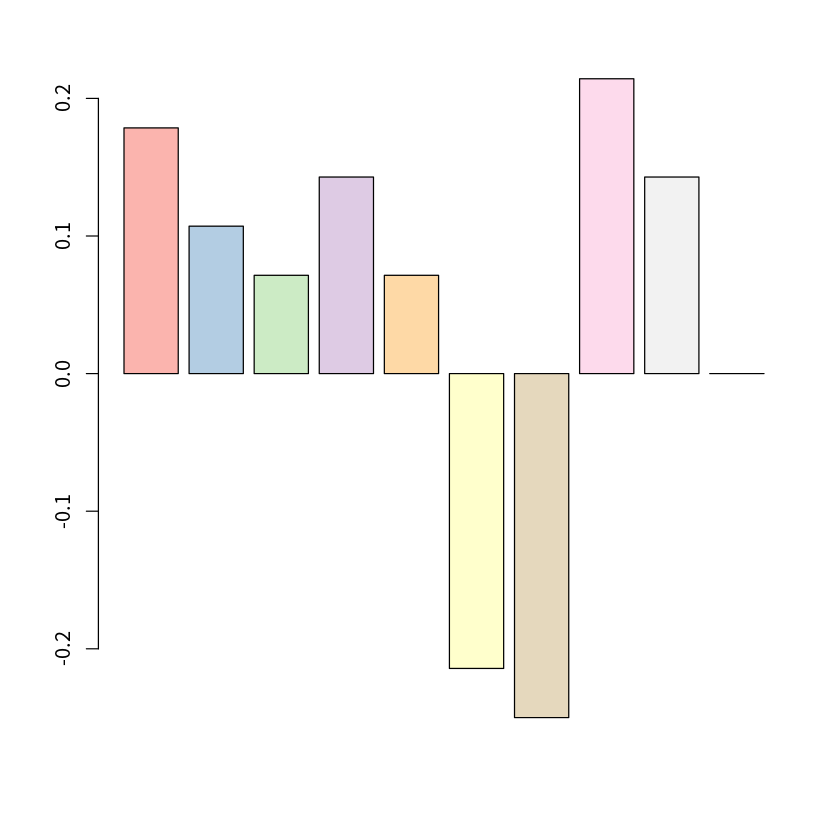

In [39]:
barplot(c(cor_S3[-1],cor2), col=c(brewer.pal(n = 9, name = "Pastel1"),"black"),ylim=c(-0.25,0.2),cex.names=0.001)

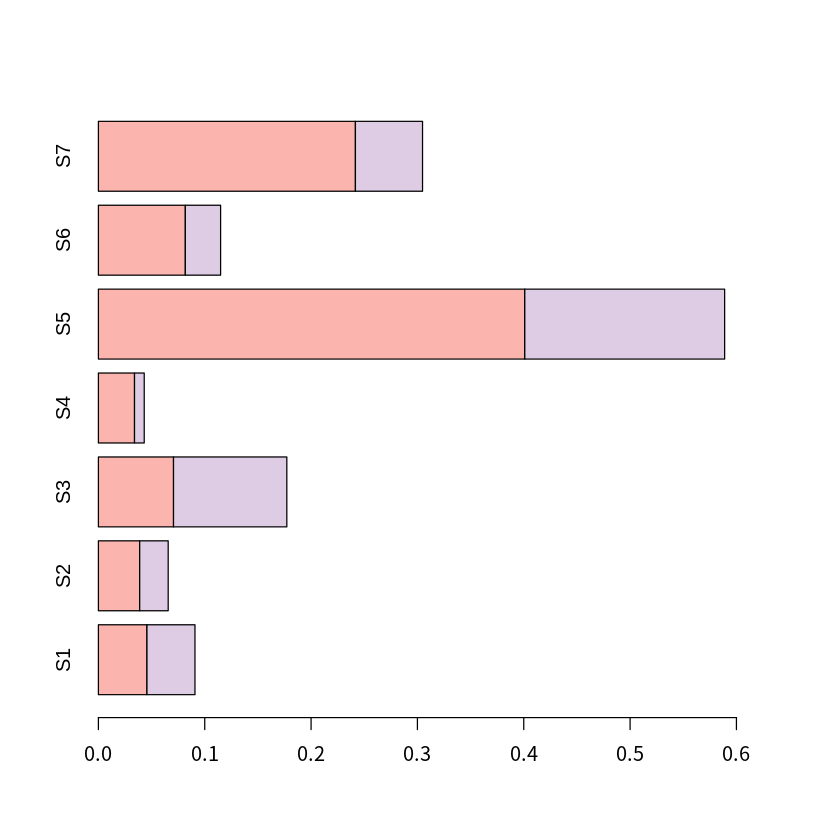

In [42]:
barplot(t(cell_stat3[,c("CD4T","CD8T")]),col=brewer.pal(n = 9, name = "Pastel1")[c(1,4)],horiz=T,xlim=c(0,0.65))

In [43]:
library(pheatmap)

               orig.ident
seurat_clusters           S1           S2           S3           S4
             12 0.9254498715 0.0051413882 0.0000000000 0.0141388175
             20 0.4129353234 0.3582089552 0.0049751244 0.0298507463
             0  0.1625231911 0.2604823748 0.0051948052 0.3361781076
             1  0.0120675784 0.0060337892 0.0000000000 0.0108608206
             9  0.2069550466 0.2519083969 0.0186598813 0.2137404580
             26 0.7142857143 0.1190476190 0.0000000000 0.0238095238
             5  0.0108765195 0.9609724888 0.0000000000 0.0204734485
             10 0.0137659784 0.0029498525 0.0000000000 0.9793510324
             21 0.0055248619 0.0000000000 0.0000000000 0.0000000000
             8  0.0084745763 0.0008474576 0.0008474576 0.0101694915
             25 0.0000000000 0.0000000000 0.0000000000 1.0000000000
             13 0.0000000000 0.0000000000 0.0000000000 0.0000000000
             4  0.0402993667 0.0708117444 0.0368451353 0.0506620610
             15 0.0496

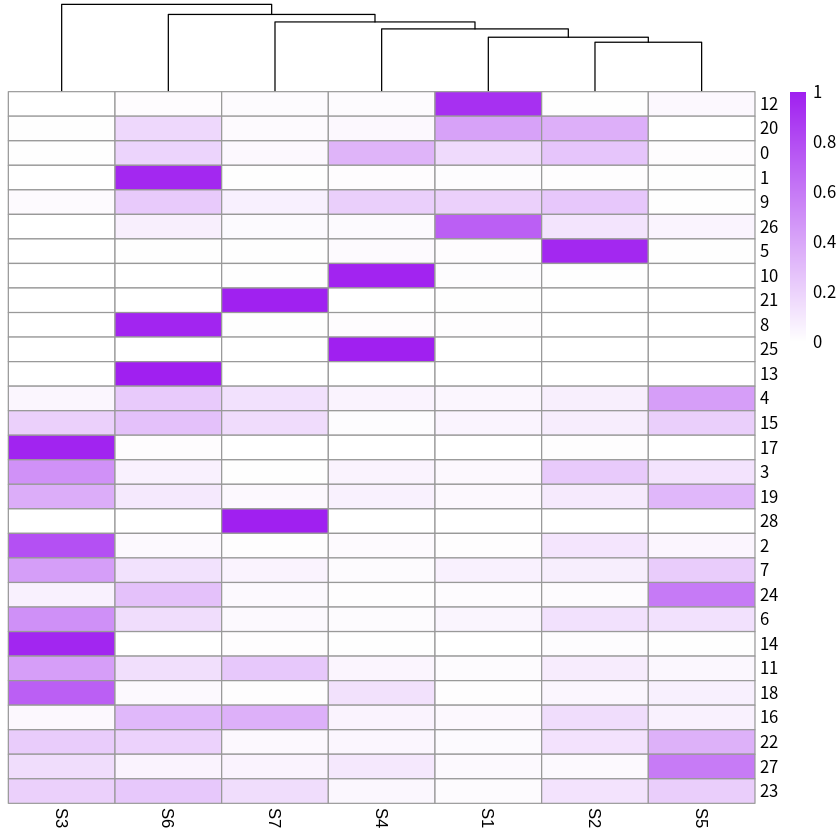

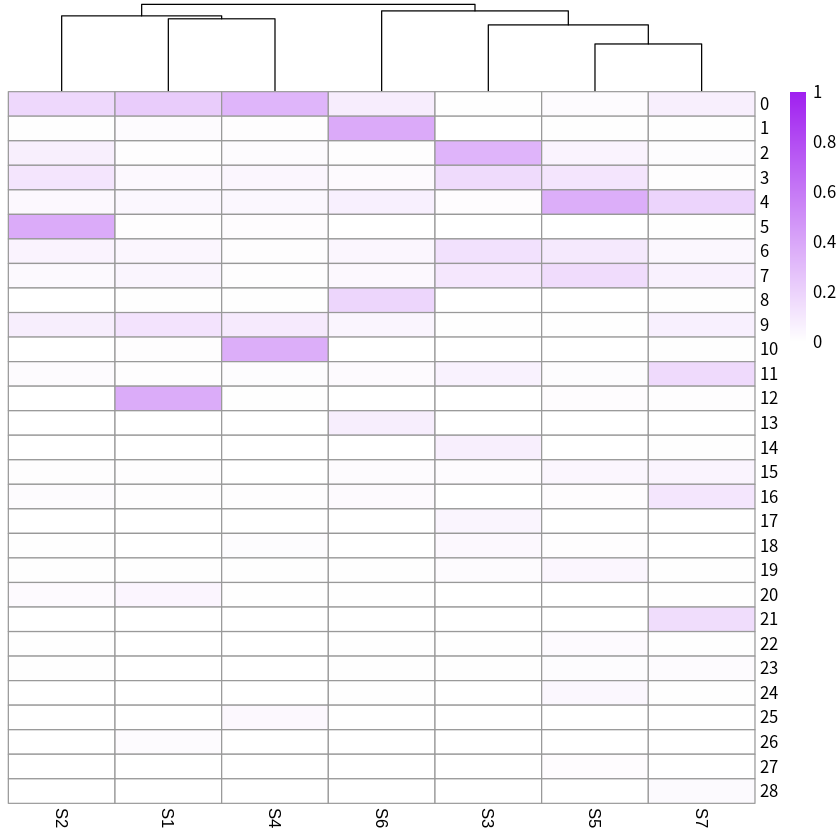

In [44]:

####
unique(SCLC.filter@meta.data[,c("seurat_clusters", "celltype")])->cell_type_unique
as.vector(cell_type_unique[order(cell_type_unique[,2]),])->order_cluster

table(SCLC.filter@meta.data[,c("seurat_clusters","orig.ident")])->sample_cluster
sample_cluster/rowSums(sample_cluster)->clluster_percentage
clluster_percentage[order_cluster[,1],]


pheatmap(clluster_percentage[order_cluster[,1],],color=colorRampPalette(c("white", "purple"))(500),breaks=seq(0,1,length=500),cluster_rows=F)


t(t(sample_cluster)/colSums(sample_cluster))->norm_sample_cluster
pheatmap(norm_sample_cluster,color=colorRampPalette(c("white", "purple"))(500),breaks=seq(0,1,length=500),cluster_rows=F)



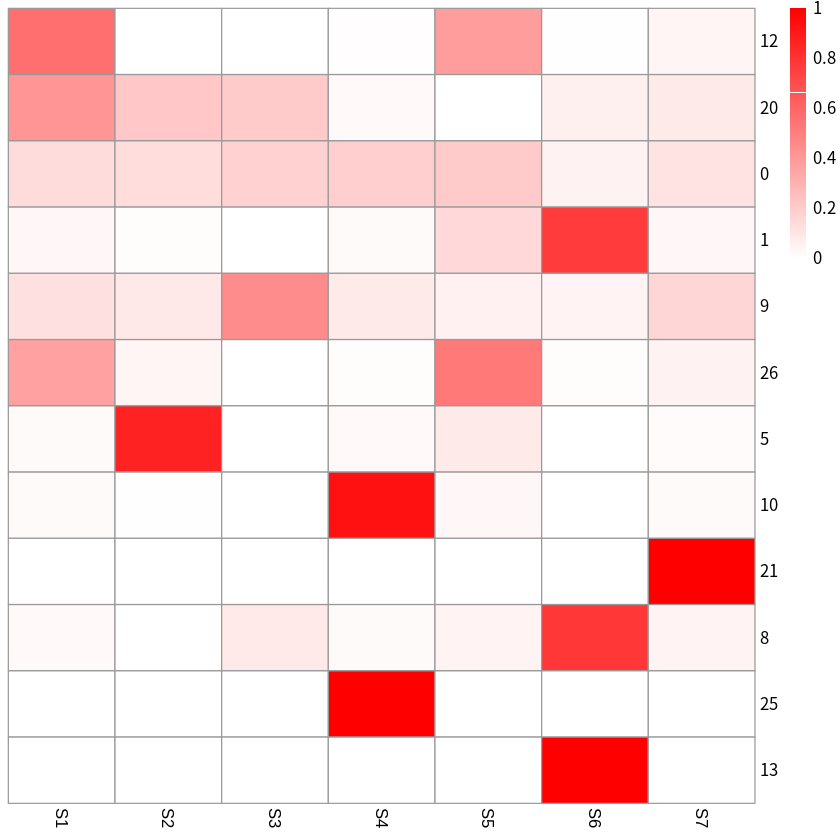

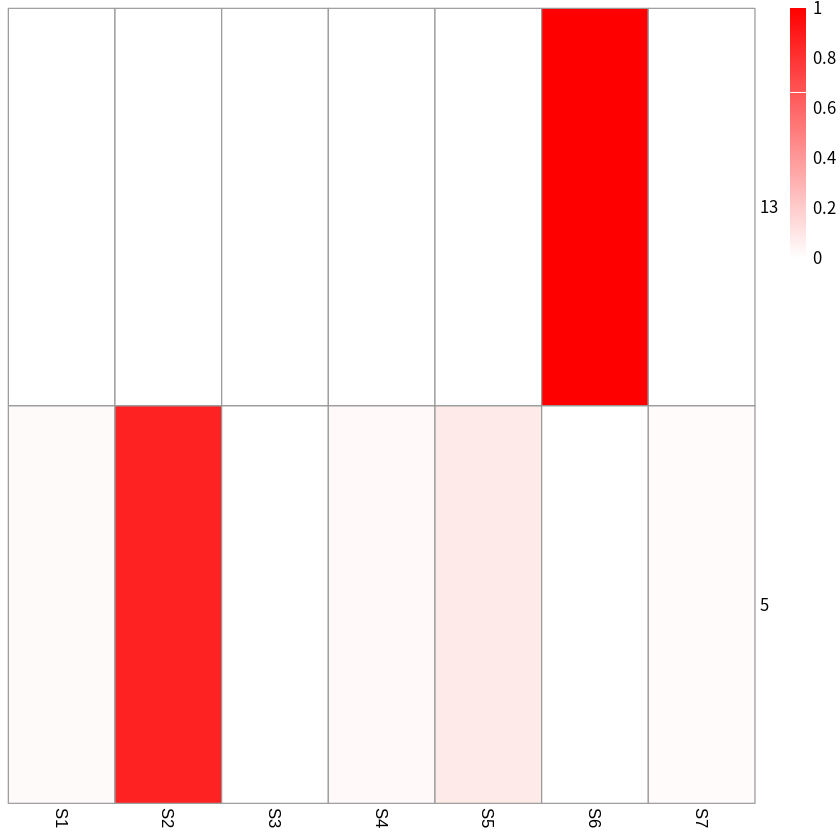

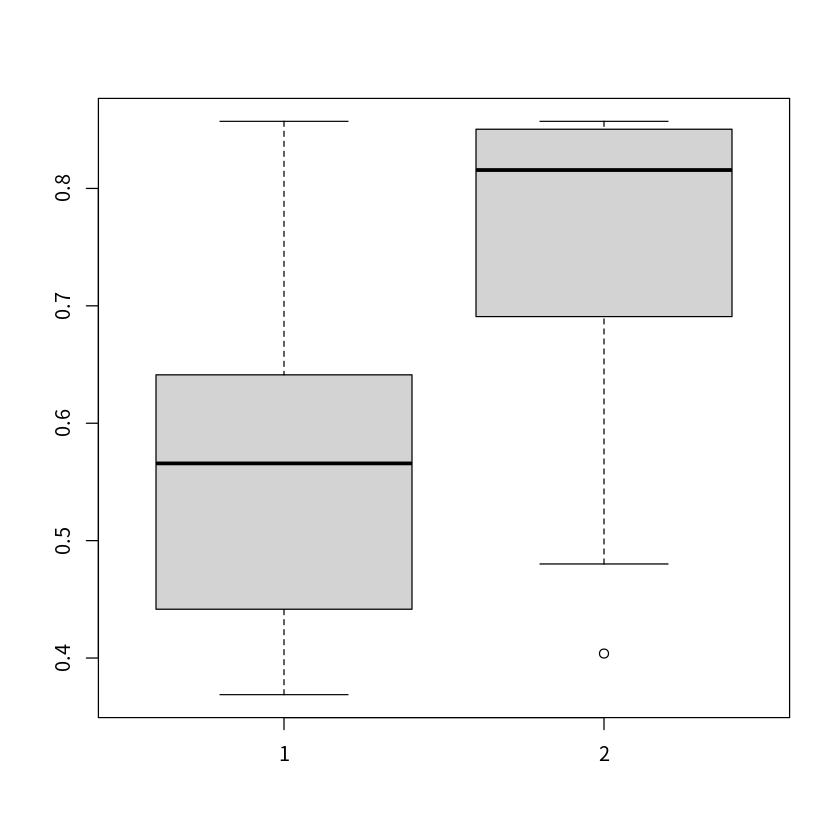

In [45]:
##### genni index
library(ineq)
#ineq(x)

apply(norm_sample_cluster,1,Gini)->Genni_index


subset(data.frame(order_cluster),celltype=="tumor")-> order_cluster_subset
sample_cluster[order_cluster_subset[,1],]-> sample_cluster2
t(t(sample_cluster2[])/colSums(sample_cluster2))->norm_sample_cluster

norm_sample_cluster/rowSums(norm_sample_cluster)-> norm_sample_cluster2
pheatmap(norm_sample_cluster2,color=colorRampPalette(c("white", "red"))(500),breaks=seq(0,1,length=500),cluster_rows=F, cluster_cols=F)
pheatmap(norm_sample_cluster2[dim(norm_sample_cluster2),],color=colorRampPalette(c("white", "red"))(500),breaks=seq(0,1,length=500),cluster_rows=F, cluster_cols=F)


boxplot(Genni_index[subset(data.frame(order_cluster),celltype!="tumor")[,1]],Genni_index[subset(data.frame(order_cluster),celltype=="tumor")[,1]])
data.frame(score=Genni_index[subset(data.frame(order_cluster),celltype=="tumor")[,1]],type="cancer cells")->T1
data.frame(score=Genni_index[subset(data.frame(order_cluster),celltype!="tumor")[,1]],type="non-cancer cells")->T2
data.frame(rbind(T1,T2))->genni_all



In [46]:
library(ggplot2)
library(tidyverse)
library(hrbrthemes)
library(viridis)

In [47]:
library(ggsignif)
compaired <- list(c("cancer cells","non-cancer cells"))

Warning message in wilcox.test.default(c(0.818895412520596, 0.663617561694585, 0.480133193801857, :
“cannot compute exact p-value with ties”


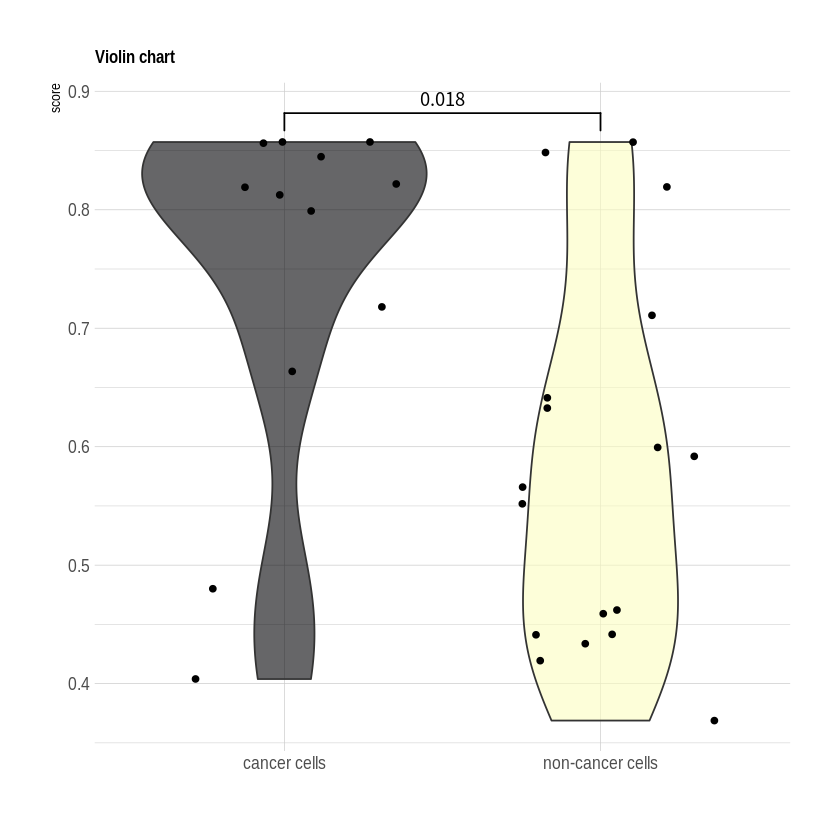

In [48]:
  ggplot(genni_all, aes(x=type, y=score, fill=type)) +
    geom_violin() + geom_jitter() +
   scale_fill_viridis(discrete = TRUE, alpha=0.6, option="A") +
    theme_ipsum() +
    theme(legend.position="none",
      plot.title = element_text(size=11)) +
    ggtitle("Violin chart") +
    xlab("") +
    geom_signif(comparisons = compaired,step_increase = 0.1,map_signif_level = F,test = wilcox.test)

In [49]:
## save work 
# save(SCLC.filter,file = "data_out/2.SCLC.filter.rdata")


In [26]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 16.04.7 LTS

Matrix products: default
BLAS/LAPACK: /home/inspur/miniconda3/envs/sclc_ldk/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=zh_CN.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] reticulate_1.22       viridis_0.6.2         viridisLite_0.4.0    
 [4] hrbrthemes_0.8.0      forcats_0.5.1         stringr_1.4.0        
 [7] dplyr_1.0.7           purrr_0.3.4           readr_2.1.1          
[10] tidyr_1.1.4           tibble_3.1.6          tidyverse_1.3.1      
[13]